[ENGIE’s first open data windfarm](https://opendata-renewables.engie.com/)

[La Haute Borne Data (2017-2020)](https://opendata-renewables.engie.com/explore/dataset/01c55756-5cd6-4f60-9f63-2d771bb25a1a/table)

[Data Descriptions](https://opendata-renewables.engie.com/explore/dataset/39490fd2-04a2-4622-9042-ce4dd34c2a58/information)

To Do:
- Read: https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1
- unsupervised anomaly techniques
- outside of x stds from certain days
- ways of determining acceptable bounds

In [1]:
import pandas as pd
import numpy as np
import re
import pickle
import string

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# Anomaly detection tools
from sklearn.ensemble import IsolationForest

# Display data tools
from IPython.display import display
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Unpickle windfarm

In [2]:
windfarm2016 = pd.read_pickle("./windfarm2016.pkl")
windfarm2016

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
13872,R80736,2016-11-26T20:30:00+01:00,2016-11-26,19:30:00,2016,11,90.000000,90.000000,90.000000,0.00,16.040001,16.000000,17.00,0.15,4.21000,4.130000,4.28000,0.030000,25.370001,24.980000,25.680000,0.120000,-0.150000,-0.440000,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.150000,0.000000,0.440000,0.080000,1.00,1.00,1.00,0.00,0.000000,0.000000,0.00000,0.000000,19.889999,19.700001,19.900000,0.04,16.830000,16.799999,17.000000,0.06,21.549999,21.400000,21.600000,0.08,26.100000,26.000000,26.100000,0.01,26.700001,26.700001,26.799999,0.01,25.420000,24.799999,25.600000,0.22,29.200001,29.100000,29.299999,0.01,234.030000,234.030000,234.030000,0.00,15.990000,15.800000,16.000000,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,133.670000,123.090000,143.130000,5.510000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-100.37,-110.940000,-90.900002,5.510000,9.00,8.8,9.05,0.02,50.000000,49.959999,50.029999,0.01,695.89001,694.01001,698.37000,0.81,0.000000,0.000000,0.00,0.00,17.299999,17.299999,17.400000,0.01,0.000000,0.00000,0.000000,0.000000,NaN,NaN,NaN,NaN,133.670000,NaN,NaN,NaN,133.670000,NaN,NaN,NaN
13875,R80736,2016-11-26T22:30:00+01:00,2016-11-26,21:30:00,2016,11,90.000000,90.000000,90.000000,0.00,16.000000,16.000000,16.00,0.00,4.07000,4.030000,4.10000,0.010000,24.190001,23.980000,24.360001,0.060000,-0.130000,-0.430000,0.000000,0.070000,0.000000,0.000000,0.000000,0.000000,0.130000,0.000000,0.430000,0.070000,1.00,1.00,1.00,0.00,0.000000,0.000000,0.00000,0.000000,19.260000,19.100000,19.299999,0.07,16.200001,16.100000,16.200001,0.00,20.500000,20.400000,20.500000,0.01,25.299999,25.250000,25.500000,0.02,25.900000,25.850000,25.900000,0.01,24.570000,24.250000,24.799999,0.08,28.190001,28.100000,28.200001,0.02,234.030000,234.030000,234.030000,0.00,15.830000,15.800000,16.000000,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,150.060000,123.090000,205.460010,25.150000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-84.00,-110.930000,-28.559999,25.150000,8.66,8.5,8.75,0.07,50.020000,49.990002,50.040001,0.01,696.19000,693.65002,698.51001,1.47,0.000000,0.000000,0.00,0.00,17.000000,16.950001,17.000000,0.00,0.000000,0.00000,0.000000,0.000000,NaN,NaN,NaN,NaN,150.060000,NaN,NaN,NaN,150.060000,NaN,NaN,NaN
13878,R80736,2016-11-30T00:40:00+01:00,2016-11-29,23:40:00,2016,11,45.000000,45.000000,45.000000,0.00,9.000000,9.000000,9.94,0.05,94.43000,73.129997,107.93000,8.530000,28.719999,28.450001,28.969999,0.080000,-1.310000,-1.780000,-0.930000,0.140000,0.000000,0.000000,0.090000,0.000000,1.310000,0.930000,1.780000,0.140000,1.00,1.00,1.00,0.00,90.470001,68.980003,104.04000,8.520001,41.369999,41.200001,41.599998,0.12,35.139999,34.900002,35.500000,0.14,54.889999,54.599998,55.400002,0.21,46.560001,46.400002,46.599998,0.07,47.500000,47.299999,47.700001,0.14,47.549999,47.200001,47.900002,0.15,49.990002,49.799999,50.200001,0.10,81.459999,81.459999,81.459999,0.00,21.459999,2

In [3]:
windfarm = pd.read_pickle("./windfarm.pkl")
windfarm

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
0,R80721,2017-02-08T08:00:00+01:00,2017-02-08,07:00:00,2017,2,44.990002,44.990002,44.990002,0.00,14.00,14.00,14.0,0.00,38.369999,17.6800,52.41000,9.390000,2.39,2.06,2.69,0.09,-1.89000,-2.36000,-1.40000,0.150000,0.000000,0.000000,0.000000,0.00,1.89000,1.40000,2.36000,0.15,1.00,1.0,1.00,0.0,38.110001,17.27,51.919998,9.400000,33.410000,33.200001,33.599998,0.14,30.790001,30.600000,30.850000,0.03,45.590000,45.299999,45.799999,0.11,35.360001,35.099998,35.599998,0.15,37.939999,37.799999,38.000000,0.08,34.130001,31.799999,35.700001,1.04,39.580002,39.049999,40.200001,0.40,318.12000,318.12000,318.12000,0.00,20.610001,20.500000,20.799999,0.08,0.14,0.00,1.94,0.44,0.22,0.00,1.93,0.53,0.18,0.00,1.89,0.44,358.049990,298.76999,54.560001,12.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.939999,-19.350000,96.449997,12.05,4.80,4.8,4.90,0.01,50.000000,49.959999,50.029999,0.01,698.40002,696.01001,708.03003,2.40,0.33,0.00,0.49,0.16,19.020000,19.0,19.100000,0.04,-18.889999,-438.32999,0.00000,79.82000,NaN,NaN,NaN,NaN,358.04999,NaN,NaN,NaN,358.04999,NaN,NaN,NaN
1,R80721,2017-01-26T02:40:00+01:00,2017-01-26,01:40:00,2017,1,-1.000000,-1.000000,-1.000000,0.00,10.00,10.00,10.0,0.00,1204.140000,1195.8101,1208.66000,3.260000,1796.71,1764.35,1816.86,10.58,197.32001,186.07001,200.96001,2.150000,22.200001,16.120001,25.110001,1.04,198.58000,186.92999,202.14999,2.17,0.99,1.0,0.99,0.0,1205.520000,1197.17,1210.060100,3.250000,40.639999,40.200001,41.099998,0.17,29.379999,29.150000,29.600000,0.08,54.580002,53.500000,55.799999,0.37,64.800003,64.550003,65.000000,0.08,64.400002,64.300003,64.599998,0.08,54.959999,54.700001,55.599998,0.12,56.209999,56.000000,56.450001,0.07,63.48000,63.48000,63.48000,0.00,21.900000,21.700001,22.200001,0.13,4.33,3.42,5.54,0.39,5.38,3.74,6.69,0.46,4.85,3.67,6.01,0.39,74.470001,9.47000,108.520000,9.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.000000,-54.009998,45.029999,9.74,-7.16,-7.3,-6.90,0.11,50.009998,49.980000,50.029999,0.01,704.65997,703.42999,705.90002,0.45,11.48,11.37,11.54,0.03,21.610001,21.6,21.799999,0.03,1562.970000,1481.31010,1586.53000,13.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,R80721,2017-01-26T13:50:00+01:00,2017-01-26,12:50:00,2017,1,-1.000000,-1.000000,-1.000000,0.00,10.00,10.00,10.0,0.00,1179.860000,1060.6200,1287.86000,49.009998,1662.15,1251.04,2029.50,164.30,176.45000,108.74000,245.96001,29.559999,18.620001,11.780000,24.469999,2.48,177.53000,110.14000,246.80000,29.35,0.99,1.0,0.98,0.0,1181.700000,1062.28,1289.950000,49.110001,49.509998,48.849998,50.099998,0.21,37.349998,37.000000,37.700001,0.13,63.990002,62.599998,65.500000,0.56,66.800003,66.099998,67.349998,0.27,66.290001,65.750000,66.900002,0.34,56.830002,56.450001,57.150002,0.11,58.570000,58.299999,59.049999,0.09,70.07000,70.07000,70.07000,0.00,27.410000,27.299999,27.700001,0.11,4.89,3.64,6.39,0.52,5.19,3.65,6.69,0.52,5.04,3.70,6.38,0.48,73.949997,328.78000,122.340000,13.83,NaN,NaN,NaN,NaN

In [4]:
# Append 2 dfs
windfarm = windfarm2016.append(windfarm)

In [5]:
windfarm['Date_time'] = pd.to_datetime(windfarm.Date_time, utc=True)

# Break up windfarm df into 4 - 1 per Turbine

In [6]:
windfarm.Wind_turbine_name.value_counts()

R80711    107131
R80721    107131
R80736    107131
R80790    106987
Name: Wind_turbine_name, dtype: int64

In [7]:
wf_R80721 = windfarm[windfarm['Wind_turbine_name']== 'R80721'].reset_index()

In [8]:
wf_R80721 = wf_R80721.drop(columns=['index'])

In [9]:
wf_R80711 = windfarm[windfarm['Wind_turbine_name']== 'R80711'].reset_index()

In [10]:
wf_R80711 = wf_R80711.drop(columns=['index'])

In [11]:
wf_R80736 = windfarm[windfarm['Wind_turbine_name']== 'R80736'].reset_index()

In [12]:
wf_R80736 = wf_R80736.drop(columns=['index'])

In [13]:
wf_R80790 = windfarm[windfarm['Wind_turbine_name']== 'R80790'].reset_index()

In [14]:
wf_R80790 = wf_R80790.drop(columns=['index'])

## Isolation Forest



Train IsolationForest using various features.

Store the various variables in a NumPy array to use in models later.

Compute the anomaly score for each observation. The anomaly score of an input sample is computed as the mean anomaly score of the trees in the forest.

Classify each observation as an outlier vs. non-outlier.

The visualization highlights the regions where the outliers fall.

As expected, the anomaly score reflects the shape of the underlying distribution and the outlier regions correspond to low probability areas.

However, Univariate analysis can only get us thus far. 

We may realize that some of these anomalies that determined by our models are not the anomalies we expected.

When our data is multidimensional as opposed to univariate, the approaches to anomaly detection become more computationally intensive and more mathematically complex.

In [15]:
isolation_forest = IsolationForest(n_estimators=100)

### Univariate Anomaly Detection on Pitch_angle averages

In [16]:
isolation_forest.fit(windfarm['Ba_avg'].dropna().values.reshape(-1, 1))

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [17]:
xx = np.linspace(windfarm['Ba_avg'].min(), windfarm['Ba_avg'].max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


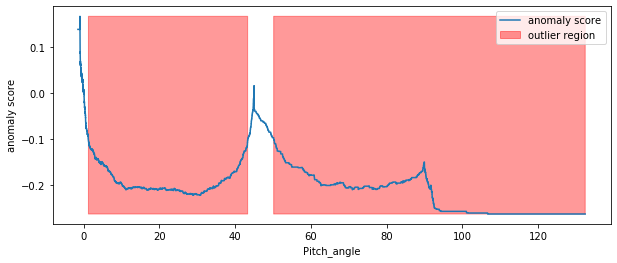

In [18]:
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Pitch_angle')
plt.show();

According to the above results and visualization, It seems that Pitch_angle average between 5 and ~42 and 58 and 130 would be definitely considered as outliers.

In [19]:
# # Visually investigate some of these anomalies
# Using Mask for Pitch_angle > 10 and less than 40, show first 5
windfarm[(windfarm.Ba_avg > 10) & (windfarm.Ba_avg < 40)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
13998,R80736,2016-05-07 10:40:00+00:00,2016-05-07,10:40:00,2016,5,27.950001,-0.99,45.0,21.530001,26.48,26.0,28.00,0.47,466.82999,105.410000,983.09003,401.67001,108.150000,-67.489998,891.59998,169.600010,-2.330000,-33.840000,56.939999,11.92,3.560000,-2.34,27.920000,6.660000,8.520001,0.39,61.590000,11.630000,1.00,-1.0,0.90,0.01,463.35999,102.170000,979.38000,401.51999,45.750000,45.000000,46.200001,0.23,42.689999,42.200001,43.099998,0.26,60.230000,58.700001,61.099998,0.40,57.470001,55.900002,58.599998,0.93,55.660000,54.799999,56.299999,0.44,52.000000,51.650002,52.450001,0.15,52.560001,52.299999,52.799999,0.12,102.43000,83.660004,111.10,12.360000,35.860001,35.700001,36.099998,0.09,3.47,0.92,5.73,0.81,3.26,0.85,5.41,0.77,3.37,1.01,5.57,0.76,77.059998,345.51001,210.74001,161.910000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.60,-125.590000,99.650002,167.789990,24.059999,23.60,24.400000,0.17,50.000000,49.970001,50.020000,0.01,696.40002,694.83002,697.82001,0.56,4.41,0.97,9.330000,3.82,29.790001,29.700001,29.799999,0.03,-96.400002,-769.70001,559.739990,179.679990,NaN,NaN,NaN,NaN,77.059998,NaN,NaN,NaN,77.059998,NaN,NaN,NaN
14040,R80736,2016-07-30 23:50:00+00:00,2016-07-30,23:50:00,2016,7,26.850000,0.50,45.0,21.660000,27.74,27.0,28.00,0.40,466.37000,84.519997,973.50000,426.14001,61.919998,22.430000,179.25999,53.439999,-8.460000,-26.059999,-3.050000,6.48,-0.180000,-15.34,2.540000,1.410000,8.660000,3.05,33.270000,6.740000,1.00,1.0,1.00,0.00,463.31000,81.419998,970.34998,425.98999,41.240002,40.900002,42.250000,0.38,38.490002,38.099998,38.900002,0.17,60.020000,59.400002,61.750000,0.47,58.279999,56.599998,59.500000,0.97,57.610001,56.799999,58.299999,0.42,53.029999,51.200001,54.599998,1.35,55.869999,55.700001,56.000000,0.04,350.37000,350.370000,350.37,0.000000,23.760000,23.400000,24.200001,0.23,2.44,0.00,3.80,0.80,2.54,0.00,4.01,0.71,2.49,1.41,3.87,0.63,352.380000,276.88000,228.74001,26.459999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.07,-73.489998,-121.630000,26.459999,19.570000,19.40,19.700001,0.10,49.990002,49.980000,50.009998,0.01,693.28998,691.73999,694.82001,0.65,4.42,0.77,9.250000,4.05,34.150002,34.000000,34.200001,0.08,-262.660000,-420.37000,-61.439999,108.450000,NaN,NaN,NaN,NaN,352.380000,NaN,NaN,NaN,352.380000,NaN,NaN,NaN
14053,R80736,2016-05-07 09:00:00+00:00,2016-05-07,09:00:00,2016,5,29.990000,-0.99,45.0,20.320000,26.00,26.0,26.51,0.03,474.48999,128.450000,1280.34000,429.17999,346.299990,7.570000,2169.57010,589.289980,29.370001,-18.120001,225.649990,61.59,10.820000,-13.71,62.830002,19.610001,35.860001,0.82,229.039990,62.270000,1.00,-1.0,0.52,0.04,471.16000,125.430000,1276.85000,429.10001,39.250000,38.900002,39.750000,0.17,37.320000,37.000000,37.599998,0.13,50.759998,49.700001,51.250000,0.27,53.820000,52.700001,56.000000,0.81,52.730000,51.900002,54.000000,0.48,50.299999,49.849998,50.799999,0.18,51.009998,50.599998,51.400002,0.14,108.49000,84.760002,136.34,24.290001,33.38

### Univariate Anomaly Detection on Converter_torque averages

In [20]:
isolation_forest.fit(windfarm['Cm_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['Cm_avg'].min(), windfarm['Cm_avg'].max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


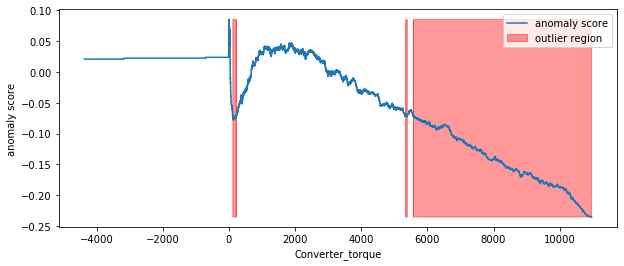

In [21]:
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Converter_torque')
plt.show();

According to the above results and visualization, it seems that the Converter_torque averages between 6000 and 11,000 would be definitely considered as outliers.

There are a couple other outlier regions, but they are not as apparent.

In [22]:
# # Visually investigate some of these anomalies
# Using Mask for Converter_torque > 6000 and less than 11000, show first 5
windfarm[(windfarm.Cm_avg > 6000) & (windfarm.Cm_avg < 11000)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
14028,R80736,2016-11-25 08:00:00+00:00,2016-11-25,08:00:00,2016,11,-0.74,-0.99,0.76,0.40,17.010000,17.0,17.940001,0.07,1735.0200,1372.5601,1839.3199,114.460000,6204.7900,2140.8799,10869.7000,2661.340100,1137.1500,279.92001,2043.6801,526.71002,81.379997,46.060001,121.18,15.65,1141.3400,288.20999,2045.2100,524.179990,0.99,1.0,0.96,0.01,1731.5100,1368.96,1835.7500,114.460000,37.590000,36.849998,38.000000,0.23,55.490002,54.700001,55.900002,0.24,66.660004,63.349998,68.300003,1.13,65.690002,63.200001,67.000000,1.15,71.410004,69.900002,72.000000,0.57,47.220001,42.799999,48.549999,1.72,55.160000,54.200001,55.650002,0.39,63.900002,63.900002,63.900002,0.0,14.270000,14.1,14.300000,0.04,9.46,4.86,14.650000,2.18,8.91,4.40,13.53,1.91,9.19,4.63,14.090000,2.02,57.950001,4.140000,94.860001,11.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.02,-59.770000,30.959999,11.80,8.41,8.40,8.5,0.02,49.990002,49.970001,50.020000,0.01,713.34003,709.88000,716.00000,1.70,16.520000,13.05,17.530001,1.10,27.00,27.000000,27.000000,0.00,6140.4800,1945.01,10799.40,2670.7300,NaN,NaN,NaN,NaN,57.950001,NaN,NaN,NaN,57.950001,NaN,NaN,NaN
14049,R80736,2016-11-04 22:30:00+00:00,2016-11-04,22:30:00,2016,11,-0.97,-0.99,-0.49,0.09,16.709999,16.0,17.000000,0.38,1797.8199,1674.8300,1825.7600,22.440001,6161.6401,3140.5801,9453.8398,1233.540000,1155.1801,546.56000,1779.6801,236.48000,80.900002,55.549999,108.13,11.59,1158.2800,556.57001,1781.2800,235.460010,1.00,1.0,0.98,0.00,1794.6600,1671.49,1822.5800,22.459999,34.860001,33.900002,36.099998,0.55,31.680000,31.000000,32.099998,0.25,55.639999,53.900002,57.450001,0.81,72.010002,71.150002,73.150002,0.51,74.209999,73.599998,74.650002,0.26,55.049999,52.299999,58.799999,2.63,59.590000,58.900002,60.400002,0.34,206.590000,206.590000,206.590000,0.0,21.290001,18.1,22.500000,1.05,9.12,5.48,12.900000,1.36,8.74,5.93,11.75,1.11,8.93,5.91,12.320000,1.19,206.170000,178.410000,248.910000,10.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.47,-28.180000,42.320000,10.04,9.14,9.00,9.3,0.08,49.990002,49.970001,50.009998,0.01,707.00000,703.97998,709.29999,1.18,17.129999,15.95,17.410000,0.22,27.77,27.700001,27.799999,0.04,6138.6401,3116.97,9415.21,1230.1200,NaN,NaN,NaN,NaN,206.170000,NaN,NaN,NaN,206.170000,NaN,NaN,NaN
14062,R80736,2016-11-16 13:00:00+00:00,2016-11-16,13:00:00,2016,11,-0.96,-0.99,0.83,0.18,15.380000,15.0,16.000000,0.42,1802.3199,1760.3199,1834.8900,9.410000,6494.5601,3542.1001,10690.8000,1199.840000,1218.9000,649.75000,2005.3300,226.59000,79.589996,52.990002,111.34,14.14,1221.6400,653.97998,2007.6200,226.280000,1.00,1.0,0.99,0.00,1798.9800,1756.89,1831.5400,9.400000,38.250000,36.950001,39.450001,0.63,34.009998,33.799999,34.349998,0.12,60.040001,57.849998,61.599998,0.86,72.820000,71.699997,73.800003,0.55,74.519997,74.099998,75.000000,0.21,53.459999,52.750000,56.700001,0.61,59.360001,58.650002,60.099998,0.31,218.660000,218.660000,218.660000,0.0,25.330000,25.1,26.200001,0.24,9.10,5

### Univariate Anomaly Detection on Power_factor averages

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

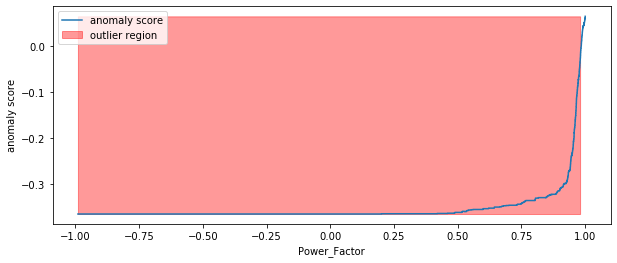

In [23]:
isolation_forest.fit(windfarm['Cosphi_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['Cosphi_avg'].min(), windfarm['Cosphi_avg'].max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Power_Factor')
plt.show();

According to the above results and visualization, it seems that the Power_Factor averages between .1 and .9 would be definitely considered as outliers.


In [24]:
# # Visually investigate some of these anomalies
# Using Mask for Power_Factor > .1 and < .9, show first 5
windfarm[(windfarm.Cosphi_avg > .1) & (windfarm.Cosphi_avg < .9)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
14189,R80736,2016-05-04 11:50:00+00:00,2016-05-04,11:50:00,2016,5,0.22,-0.99,11.19,1.84,20.690001,20.0,21.6,0.46,989.08002,963.190000,1213.65000,45.080002,489.51001,11.12000,1775.17000,347.95001,23.030001,-23.35,170.280000,34.950001,44.389999,-3.470000,78.279999,22.17,58.689999,1.330000,173.630000,27.840000,0.86,-1.00,0.05,0.33,985.95001,960.000000,1210.58000,45.090000,45.189999,44.700001,45.700001,0.19,41.220001,41.000000,41.500000,0.10,62.169998,60.849998,63.700001,0.51,58.139999,56.900002,58.700001,0.37,56.669998,56.299999,56.900002,0.16,52.849998,52.349998,53.150002,0.12,53.459999,53.150002,53.700001,0.09,104.44000,92.440002,110.00,8.01,32.299999,32.000000,32.700001,0.15,4.34,2.84,6.70,0.70,4.07,2.70,6.38,0.65,4.20,2.87,6.54,0.65,71.839996,261.810000,147.10001,408.090000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-20.629999,169.370000,37.099998,400.570010,16.60,16.0,17.1,0.26,49.980000,49.959999,50.009998,0.01,697.84998,694.64001,699.40002,0.88,9.380000,9.12,11.520000,0.43,26.969999,26.900000,27.00,0.04,219.34000,-229.910000,1485.06010,327.17999,NaN,NaN,NaN,NaN,71.839996,NaN,NaN,NaN,71.839996,NaN,NaN,NaN
14203,R80736,2016-11-12 12:20:00+00:00,2016-11-12,12:20:00,2016,11,11.88,-0.50,45.00,19.43,13.020000,13.0,14.0,0.13,758.72998,71.419998,975.97998,366.310000,244.31000,0.20000,629.46002,200.91000,3.270000,-24.25,35.869999,14.430000,47.279999,-0.510000,78.190002,30.01,49.349998,0.810000,85.830002,30.360001,0.68,1.00,0.08,0.35,755.59998,67.720001,972.82001,366.269990,24.900000,24.200001,25.400000,0.32,22.580000,22.000000,23.100000,0.28,39.110001,37.500000,40.000000,0.55,46.549999,44.750000,47.000000,0.56,40.869999,40.400002,41.099998,0.21,33.160000,31.600000,35.049999,1.02,36.360001,36.099998,36.599998,0.07,164.03999,147.320010,176.95,14.24,17.520000,17.400000,17.700001,0.10,2.76,0.00,4.62,1.42,3.30,0.00,4.66,0.89,3.03,0.00,4.64,1.09,139.910000,100.510000,200.02000,148.410000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.390000,-46.810001,52.709999,158.170000,6.17,5.7,6.8,0.35,49.950001,49.930000,49.980000,0.01,698.72998,695.48999,702.40997,1.61,7.200000,0.65,9.270001,3.48,16.910000,16.700001,17.00,0.08,7.76000,-239.220000,353.23999,156.16000,NaN,NaN,NaN,NaN,139.910000,NaN,NaN,NaN,139.910000,NaN,NaN,NaN
14495,R80736,2016-11-01 11:30:00+00:00,2016-11-01,11:30:00,2016,11,-0.51,-0.99,0.00,0.38,17.020000,17.0,18.0,0.11,973.53003,967.539980,984.17999,2.570000,670.98999,295.20001,1003.82000,169.24001,39.240002,2.26,73.040001,16.700001,73.940002,59.529999,80.699997,3.48,85.139999,70.070000,98.040001,7.220000,0.45,0.77,0.05,0.16,970.09003,963.989990,980.78003,2.570000,37.490002,37.000000,38.099998,0.22,31.290001,30.799999,31.799999,0.23,50.360001,48.500000,51.900002,0.64,54.820000,54.500000,55.200001,0.16,53.169998,52.900002,53.299999,0.10,49.080002,48.849998,49.450001,0.09,49.840000,49.549999,50.099998,0.07,155.00000,155.000000,155.00,0.00,25.500000,25.299999,25.700001,0.11,3.

## Univariate Anomaly Detection on Generator_converter_speed

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

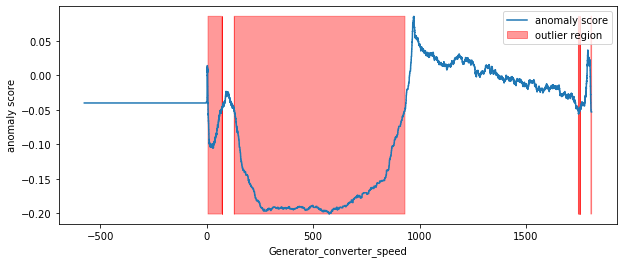

In [25]:
isolation_forest.fit(windfarm['DCs_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['DCs_avg'].min(), windfarm['DCs_avg'].max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Generator_converter_speed')
plt.show();

According to the above results and visualization, it seems that the Generator_converter_speed averages between ~200 and ~900 would be definitely considered as outliers.

There are several other outlier regions, as well, but they are not as apparent.

In [26]:
# # Visually investigate some of these anomalies
# Using Mask for Generator_converter_speed > 200 and < 900, show first 5
windfarm[(windfarm.DCs_avg > 200) & (windfarm.DCs_avg < 900)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
13998,R80736,2016-05-07 10:40:00+00:00,2016-05-07,10:40:00,2016,5,27.950001,-0.99,45.0,21.530001,26.48,26.0,28.00,0.47,466.82999,105.410000,983.09003,401.67001,108.150000,-67.489998,891.59998,169.600010,-2.330000,-33.840000,56.939999,11.92,3.560000,-2.34,27.920000,6.660000,8.520001,0.39,61.590000,11.630000,1.00,-1.0,0.90,0.01,463.35999,102.170000,979.38000,401.51999,45.750000,45.000000,46.200001,0.23,42.689999,42.200001,43.099998,0.26,60.230000,58.700001,61.099998,0.40,57.470001,55.900002,58.599998,0.93,55.660000,54.799999,56.299999,0.44,52.000000,51.650002,52.450001,0.15,52.560001,52.299999,52.799999,0.12,102.43000,83.660004,111.10,12.360000,35.860001,35.700001,36.099998,0.09,3.47,0.92,5.73,0.81,3.26,0.85,5.41,0.77,3.37,1.01,5.57,0.76,77.059998,345.51001,210.74001,161.910000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.60,-125.590000,99.650002,167.789990,24.059999,23.60,24.400000,0.17,50.000000,49.970001,50.020000,0.01,696.40002,694.83002,697.82001,0.56,4.41,0.97,9.330000,3.82,29.790001,29.700001,29.799999,0.03,-96.400002,-769.70001,559.739990,179.679990,NaN,NaN,NaN,NaN,77.059998,NaN,NaN,NaN,77.059998,NaN,NaN,NaN
14040,R80736,2016-07-30 23:50:00+00:00,2016-07-30,23:50:00,2016,7,26.850000,0.50,45.0,21.660000,27.74,27.0,28.00,0.40,466.37000,84.519997,973.50000,426.14001,61.919998,22.430000,179.25999,53.439999,-8.460000,-26.059999,-3.050000,6.48,-0.180000,-15.34,2.540000,1.410000,8.660000,3.05,33.270000,6.740000,1.00,1.0,1.00,0.00,463.31000,81.419998,970.34998,425.98999,41.240002,40.900002,42.250000,0.38,38.490002,38.099998,38.900002,0.17,60.020000,59.400002,61.750000,0.47,58.279999,56.599998,59.500000,0.97,57.610001,56.799999,58.299999,0.42,53.029999,51.200001,54.599998,1.35,55.869999,55.700001,56.000000,0.04,350.37000,350.370000,350.37,0.000000,23.760000,23.400000,24.200001,0.23,2.44,0.00,3.80,0.80,2.54,0.00,4.01,0.71,2.49,1.41,3.87,0.63,352.380000,276.88000,228.74001,26.459999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.07,-73.489998,-121.630000,26.459999,19.570000,19.40,19.700001,0.10,49.990002,49.980000,50.009998,0.01,693.28998,691.73999,694.82001,0.65,4.42,0.77,9.250000,4.05,34.150002,34.000000,34.200001,0.08,-262.660000,-420.37000,-61.439999,108.450000,NaN,NaN,NaN,NaN,352.380000,NaN,NaN,NaN,352.380000,NaN,NaN,NaN
14053,R80736,2016-05-07 09:00:00+00:00,2016-05-07,09:00:00,2016,5,29.990000,-0.99,45.0,20.320000,26.00,26.0,26.51,0.03,474.48999,128.450000,1280.34000,429.17999,346.299990,7.570000,2169.57010,589.289980,29.370001,-18.120001,225.649990,61.59,10.820000,-13.71,62.830002,19.610001,35.860001,0.82,229.039990,62.270000,1.00,-1.0,0.52,0.04,471.16000,125.430000,1276.85000,429.10001,39.250000,38.900002,39.750000,0.17,37.320000,37.000000,37.599998,0.13,50.759998,49.700001,51.250000,0.27,53.820000,52.700001,56.000000,0.81,52.730000,51.900002,54.000000,0.48,50.299999,49.849998,50.799999,0.18,51.009998,50.599998,51.400002,0.14,108.49000,84.760002,136.34,24.290001,33.38

### Univariate Anomaly Detection on Generator_bearing_1_temperature

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

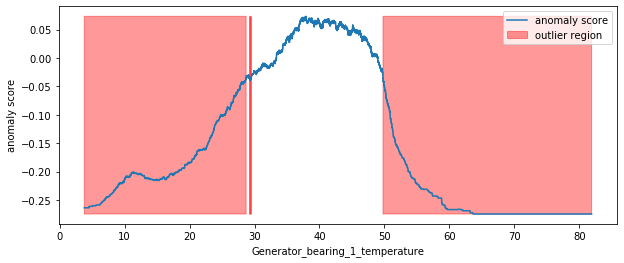

In [27]:
isolation_forest.fit(windfarm['Db1t_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['Db1t_avg'].min(), windfarm['Db1t_avg'].max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Generator_bearing_1_temperature')
plt.show();

According to the above results and visualization, it seems that the Generator_bearing_1_temperature averages between 5 and 25 and also 50 and 80 would be definitely considered as outliers.


In [28]:
# # Visually investigate some of these anomalies
# Using Mask for Generator_bearing_1_temperature > 5 < 25, show first 5
windfarm[(windfarm.Db1t_avg > 5) & (windfarm.Db1t_avg < 25)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
13872,R80736,2016-11-26 19:30:00+00:00,2016-11-26,19:30:00,2016,11,90.00,90.00,90.0,0.00,16.040001,16.0,17.0,0.15,4.21,4.130000,4.28000,0.030000,25.370001,24.980000,25.680000,0.120000,-0.15,-0.44,0.000000,0.08,0.00,0.00,0.00,0.00,0.15,0.00,0.440000,0.08,1.0,1.0,1.0,0.0,0.000000,0.000000,0.00000,0.000000,19.889999,19.700001,19.900000,0.04,16.830000,16.799999,17.000000,0.06,21.549999,21.4,21.600000,0.08,26.100000,26.000000,26.100000,0.01,26.700001,26.700001,26.799999,0.01,25.420000,24.799999,25.600000,0.22,29.200001,29.100000,29.299999,0.01,234.03000,234.03000,234.03000,0.0,15.99,15.8,16.0,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,133.67000,123.09000,143.13000,5.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-100.370000,-110.940000,-90.900002,5.51,9.00,8.80,9.05,0.02,50.000000,49.959999,50.029999,0.01,695.89001,694.01001,698.37000,0.81,0.000000,0.00,0.00,0.00,17.299999,17.299999,17.4,0.01,0.00000,0.00000,0.00000,0.000000,NaN,NaN,NaN,NaN,133.67000,NaN,NaN,NaN,133.67000,NaN,NaN,NaN
13875,R80736,2016-11-26 21:30:00+00:00,2016-11-26,21:30:00,2016,11,90.00,90.00,90.0,0.00,16.000000,16.0,16.0,0.00,4.07,4.030000,4.10000,0.010000,24.190001,23.980000,24.360001,0.060000,-0.13,-0.43,0.000000,0.07,0.00,0.00,0.00,0.00,0.13,0.00,0.430000,0.07,1.0,1.0,1.0,0.0,0.000000,0.000000,0.00000,0.000000,19.260000,19.100000,19.299999,0.07,16.200001,16.100000,16.200001,0.00,20.500000,20.4,20.500000,0.01,25.299999,25.250000,25.500000,0.02,25.900000,25.850000,25.900000,0.01,24.570000,24.250000,24.799999,0.08,28.190001,28.100000,28.200001,0.02,234.03000,234.03000,234.03000,0.0,15.83,15.8,16.0,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,150.06000,123.09000,205.46001,25.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-84.000000,-110.930000,-28.559999,25.15,8.66,8.50,8.75,0.07,50.020000,49.990002,50.040001,0.01,696.19000,693.65002,698.51001,1.47,0.000000,0.00,0.00,0.00,17.000000,16.950001,17.0,0.00,0.00000,0.00000,0.00000,0.000000,NaN,NaN,NaN,NaN,150.06000,NaN,NaN,NaN,150.06000,NaN,NaN,NaN
13932,R80736,2016-11-14 21:00:00+00:00,2016-11-14,21:00:00,2016,11,45.00,45.00,45.0,0.00,9.000000,9.0,9.0,0.00,102.76,86.599998,126.43000,12.240000,27.910000,27.719999,28.100000,0.070000,-1.67,-2.07,-1.210000,0.14,0.00,-0.13,0.07,0.01,1.67,1.21,2.070000,0.14,1.0,1.0,1.0,0.0,98.739998,82.300003,122.52000,12.260000,21.610001,21.400000,21.700001,0.04,17.930000,17.700001,18.000000,0.06,25.309999,25.1,25.600000,0.11,33.459999,33.400002,33.500000,0.04,32.720001,32.650002,32.900002,0.05,33.099998,33.000000,33.250000,0.02,34.099998,34.000000,34.299999,0.05,161.59000,161.59000,161.59000,0.0,14.31,14.2,14.5,0.05,1.50,0.00,2.64,0.72,2.39,1.54,3.07,0.28,1.95,0.87,2.84,0.45,180.41000,144.42999,212.64000,10.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.790001,-17.150000,51.049999,10.64,-0.40,-0.45,-0.40,0.00,50.009998,50.000000,50.029999,0.01,707.56000,699.28998,709.79999,2.89,0.930000,0.77,1.16,0.12,

## Univariate Anomaly Detection on Generator_bearing_2_temperature

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

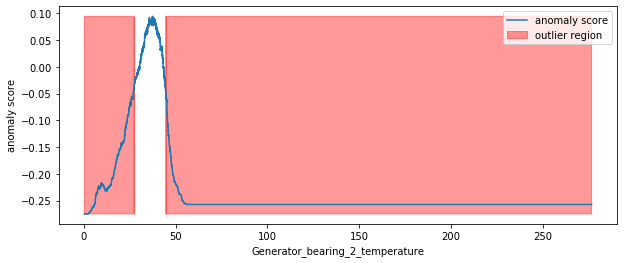

In [29]:
isolation_forest.fit(windfarm['Db2t_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['Db2t_avg'].min(), windfarm['Db2t_avg'].max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Generator_bearing_2_temperature')
plt.show();

According to the above results and visualization, it seems that the Generator_bearing_2_temperature averages between 5 and 25 and also 50 and 275 would be definitely considered as outliers.

In [30]:
# # Visually investigate some of these anomalies
# Using Mask for Generator_bearing_2_temperature > 5 < 25, show first 5
windfarm[(windfarm.Db2t_avg > 5) & (windfarm.Db2t_avg < 25)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
13872,R80736,2016-11-26 19:30:00+00:00,2016-11-26,19:30:00,2016,11,90.00,90.00,90.0,0.00,16.040001,16.0,17.0,0.15,4.21,4.130000,4.28000,0.030000,25.370001,24.980000,25.680000,0.120000,-0.15,-0.44,0.000000,0.08,0.00,0.00,0.00,0.00,0.15,0.00,0.440000,0.08,1.0,1.0,1.0,0.0,0.000000,0.000000,0.00000,0.000000,19.889999,19.700001,19.900000,0.04,16.830000,16.799999,17.000000,0.06,21.549999,21.4,21.600000,0.08,26.100000,26.000000,26.100000,0.01,26.700001,26.700001,26.799999,0.01,25.420000,24.799999,25.600000,0.22,29.200001,29.100000,29.299999,0.01,234.03000,234.03000,234.03000,0.0,15.99,15.8,16.0,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,133.67000,123.09000,143.13000,5.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-100.370000,-110.940000,-90.900002,5.51,9.00,8.80,9.05,0.02,50.000000,49.959999,50.029999,0.01,695.89001,694.01001,698.37000,0.81,0.000000,0.00,0.00,0.00,17.299999,17.299999,17.4,0.01,0.00000,0.00000,0.00000,0.000000,NaN,NaN,NaN,NaN,133.67000,NaN,NaN,NaN,133.67000,NaN,NaN,NaN
13875,R80736,2016-11-26 21:30:00+00:00,2016-11-26,21:30:00,2016,11,90.00,90.00,90.0,0.00,16.000000,16.0,16.0,0.00,4.07,4.030000,4.10000,0.010000,24.190001,23.980000,24.360001,0.060000,-0.13,-0.43,0.000000,0.07,0.00,0.00,0.00,0.00,0.13,0.00,0.430000,0.07,1.0,1.0,1.0,0.0,0.000000,0.000000,0.00000,0.000000,19.260000,19.100000,19.299999,0.07,16.200001,16.100000,16.200001,0.00,20.500000,20.4,20.500000,0.01,25.299999,25.250000,25.500000,0.02,25.900000,25.850000,25.900000,0.01,24.570000,24.250000,24.799999,0.08,28.190001,28.100000,28.200001,0.02,234.03000,234.03000,234.03000,0.0,15.83,15.8,16.0,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,150.06000,123.09000,205.46001,25.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-84.000000,-110.930000,-28.559999,25.15,8.66,8.50,8.75,0.07,50.020000,49.990002,50.040001,0.01,696.19000,693.65002,698.51001,1.47,0.000000,0.00,0.00,0.00,17.000000,16.950001,17.0,0.00,0.00000,0.00000,0.00000,0.000000,NaN,NaN,NaN,NaN,150.06000,NaN,NaN,NaN,150.06000,NaN,NaN,NaN
13932,R80736,2016-11-14 21:00:00+00:00,2016-11-14,21:00:00,2016,11,45.00,45.00,45.0,0.00,9.000000,9.0,9.0,0.00,102.76,86.599998,126.43000,12.240000,27.910000,27.719999,28.100000,0.070000,-1.67,-2.07,-1.210000,0.14,0.00,-0.13,0.07,0.01,1.67,1.21,2.070000,0.14,1.0,1.0,1.0,0.0,98.739998,82.300003,122.52000,12.260000,21.610001,21.400000,21.700001,0.04,17.930000,17.700001,18.000000,0.06,25.309999,25.1,25.600000,0.11,33.459999,33.400002,33.500000,0.04,32.720001,32.650002,32.900002,0.05,33.099998,33.000000,33.250000,0.02,34.099998,34.000000,34.299999,0.05,161.59000,161.59000,161.59000,0.0,14.31,14.2,14.5,0.05,1.50,0.00,2.64,0.72,2.39,1.54,3.07,0.28,1.95,0.87,2.84,0.45,180.41000,144.42999,212.64000,10.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.790001,-17.150000,51.049999,10.64,-0.40,-0.45,-0.40,0.00,50.009998,50.000000,50.029999,0.01,707.56000,699.28998,709.79999,2.89,0.930000,0.77,1.16,0.12,

## Univariate Anomaly Detection on Generator_speed average

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

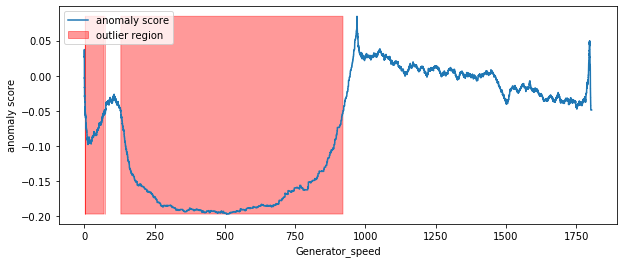

In [31]:
isolation_forest.fit(windfarm['Ds_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['Ds_avg'].dropna().min(), windfarm['Ds_avg'].dropna().max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Generator_speed')
plt.show();

According to the above results and visualization, it seems that the Generator_speed averages between 125 and 875 would be definitely considered as outliers.

There are a couple other regions with outliers that are not as obviously designated by the plot.

In [32]:
# # Visually investigate some of these anomalies
# Using Mask for Generator_speed > 125 < 875, show first 5
windfarm[(windfarm.Ds_avg > 125) & (windfarm.Ds_avg < 875)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
13998,R80736,2016-05-07 10:40:00+00:00,2016-05-07,10:40:00,2016,5,27.950001,-0.99,45.0,21.530001,26.480000,26.00,28.0,0.47,466.82999,105.410000,983.09003,401.67001,108.150000,-67.489998,891.599980,169.600010,-2.33,-33.840000,56.939999,11.92,3.56,-2.34,27.92,6.66,8.520001,0.39,61.59,11.63,1.0,-1.0,0.9,0.01,463.35999,102.170000,979.38000,401.51999,45.750000,45.000000,46.200001,0.23,42.689999,42.200001,43.099998,0.26,60.230000,58.700001,61.099998,0.40,57.470001,55.900002,58.599998,0.93,55.660000,54.799999,56.299999,0.44,52.000000,51.650002,52.450001,0.15,52.560001,52.299999,52.799999,0.12,102.430000,83.660004,111.100000,12.36,35.860001,35.700001,36.099998,0.09,3.47,0.92,5.73,0.81,3.26,0.85,5.41,0.77,3.37,1.01,5.57,0.76,77.059998,345.510010,210.740010,161.910000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.60,-125.590000,99.650002,167.789990,24.059999,23.6,24.400000,0.17,50.000000,49.970001,50.020000,0.01,696.40002,694.83002,697.82001,0.56,4.41,0.97,9.33,3.82,29.790001,29.700001,29.799999,0.03,-96.400002,-769.700010,559.739990,179.67999,NaN,NaN,NaN,NaN,77.059998,NaN,NaN,NaN,77.059998,NaN,NaN,NaN
14004,R80736,2016-12-05 16:30:00+00:00,2016-12-05,16:30:00,2016,12,45.000000,45.00,45.0,0.000000,14.000000,14.00,14.0,0.00,198.95000,192.899990,203.99001,2.12000,25.580000,25.040001,26.309999,0.270000,-1.11,-1.570000,-0.730000,0.13,0.00,-0.22,0.19,0.02,1.110000,0.73,1.57,0.13,1.0,1.0,1.0,0.00,195.46001,189.800000,200.19000,2.12000,33.189999,33.000000,33.500000,0.12,29.350000,29.000000,29.600000,0.18,39.459999,38.900002,40.000000,0.26,45.060001,44.900002,45.200001,0.08,44.299999,44.250000,44.500000,0.03,44.669998,44.500000,44.950001,0.05,45.639999,45.500000,45.799999,0.05,126.460000,126.460000,126.460000,0.00,22.750000,22.600000,22.799999,0.08,3.16,2.02,3.93,0.38,3.47,2.61,4.27,0.35,3.31,2.41,4.04,0.34,143.060000,70.440002,178.710010,8.570000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.59,-56.020000,52.240002,8.570000,6.790000,6.7,6.900000,0.02,49.990002,49.959999,50.009998,0.01,695.96002,694.15997,697.57001,0.57,1.85,1.80,1.90,0.02,19.799999,19.799999,19.799999,0.00,-54.320000,-76.500000,-34.900002,6.24000,NaN,NaN,NaN,NaN,143.060000,NaN,NaN,NaN,143.060000,NaN,NaN,NaN
14034,R80736,2016-11-27 06:00:00+00:00,2016-11-27,06:00:00,2016,11,45.000000,45.00,45.0,0.000000,16.000000,15.28,16.0,0.05,143.35001,124.320000,171.50000,9.71000,24.820000,24.620001,25.020000,0.070000,-1.16,-1.530000,-0.810000,0.13,0.00,-0.19,0.22,0.01,1.160000,0.81,1.53,0.13,1.0,1.0,1.0,0.00,139.81000,120.790000,167.48000,9.71000,43.869999,43.700001,44.000000,0.11,38.320000,38.000000,38.700001,0.22,57.470001,56.900002,58.000000,0.31,39.799999,39.500000,40.000000,0.14,38.360001,38.200001,38.599998,0.08,36.750000,36.599998,36.950001,0.05,37.310001,37.099998,37.500000,0.10,356.950010,356.950010,356.950010,0.00,25.889999,25.700001,25.900000,0.04,2.53,1.39,3.95,0.43,2.61,1.56,3.77,0.38,2.57,1.53,3.75,0.39,4.730000,307.660

### Univariate Anomaly Detection on Generator_stator_temperature

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

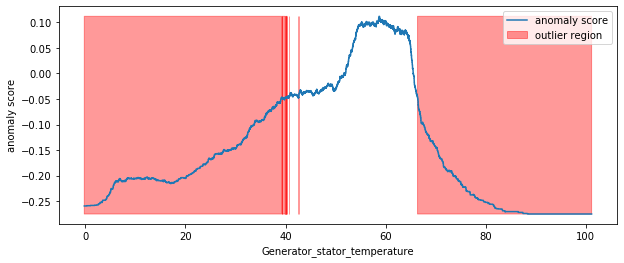

In [33]:
isolation_forest.fit(windfarm['Dst_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['Dst_avg'].min(), windfarm['Dst_avg'].max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Generator_stator_temperature')
plt.show();

According to the above results and visualization, it seems that the Generator_stator_temperature averages between 0 and 37 and 70 and 100 would be definitely considered as outliers.


In [34]:
# # Visually investigate some of these anomalies
# Using Mask for Generator_stator_temperature > 0 < 37, show first 5
windfarm[(windfarm.Dst_avg > 0) & (windfarm.Dst_avg < 37)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
13872,R80736,2016-11-26 19:30:00+00:00,2016-11-26,19:30:00,2016,11,90.00,90.00,90.0,0.00,16.040001,16.0,17.0,0.15,4.21,4.130000,4.28000,0.030000,25.370001,24.980000,25.680000,0.120000,-0.15,-0.44,0.000000,0.08,0.00,0.00,0.00,0.00,0.15,0.00,0.440000,0.08,1.0,1.0,1.0,0.0,0.000000,0.000000,0.00000,0.000000,19.889999,19.700001,19.900000,0.04,16.830000,16.799999,17.000000,0.06,21.549999,21.4,21.600000,0.08,26.100000,26.000000,26.100000,0.01,26.700001,26.700001,26.799999,0.01,25.420000,24.799999,25.600000,0.22,29.200001,29.100000,29.299999,0.01,234.03000,234.03000,234.03000,0.0,15.99,15.8,16.0,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,133.67000,123.09000,143.13000,5.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-100.370000,-110.940000,-90.900002,5.51,9.00,8.80,9.05,0.02,50.000000,49.959999,50.029999,0.01,695.89001,694.01001,698.37000,0.81,0.000000,0.00,0.00,0.00,17.299999,17.299999,17.4,0.01,0.00000,0.00000,0.00000,0.000000,NaN,NaN,NaN,NaN,133.67000,NaN,NaN,NaN,133.67000,NaN,NaN,NaN
13875,R80736,2016-11-26 21:30:00+00:00,2016-11-26,21:30:00,2016,11,90.00,90.00,90.0,0.00,16.000000,16.0,16.0,0.00,4.07,4.030000,4.10000,0.010000,24.190001,23.980000,24.360001,0.060000,-0.13,-0.43,0.000000,0.07,0.00,0.00,0.00,0.00,0.13,0.00,0.430000,0.07,1.0,1.0,1.0,0.0,0.000000,0.000000,0.00000,0.000000,19.260000,19.100000,19.299999,0.07,16.200001,16.100000,16.200001,0.00,20.500000,20.4,20.500000,0.01,25.299999,25.250000,25.500000,0.02,25.900000,25.850000,25.900000,0.01,24.570000,24.250000,24.799999,0.08,28.190001,28.100000,28.200001,0.02,234.03000,234.03000,234.03000,0.0,15.83,15.8,16.0,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,150.06000,123.09000,205.46001,25.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-84.000000,-110.930000,-28.559999,25.15,8.66,8.50,8.75,0.07,50.020000,49.990002,50.040001,0.01,696.19000,693.65002,698.51001,1.47,0.000000,0.00,0.00,0.00,17.000000,16.950001,17.0,0.00,0.00000,0.00000,0.00000,0.000000,NaN,NaN,NaN,NaN,150.06000,NaN,NaN,NaN,150.06000,NaN,NaN,NaN
13932,R80736,2016-11-14 21:00:00+00:00,2016-11-14,21:00:00,2016,11,45.00,45.00,45.0,0.00,9.000000,9.0,9.0,0.00,102.76,86.599998,126.43000,12.240000,27.910000,27.719999,28.100000,0.070000,-1.67,-2.07,-1.210000,0.14,0.00,-0.13,0.07,0.01,1.67,1.21,2.070000,0.14,1.0,1.0,1.0,0.0,98.739998,82.300003,122.52000,12.260000,21.610001,21.400000,21.700001,0.04,17.930000,17.700001,18.000000,0.06,25.309999,25.1,25.600000,0.11,33.459999,33.400002,33.500000,0.04,32.720001,32.650002,32.900002,0.05,33.099998,33.000000,33.250000,0.02,34.099998,34.000000,34.299999,0.05,161.59000,161.59000,161.59000,0.0,14.31,14.2,14.5,0.05,1.50,0.00,2.64,0.72,2.39,1.54,3.07,0.28,1.95,0.87,2.84,0.45,180.41000,144.42999,212.64000,10.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.790001,-17.150000,51.049999,10.64,-0.40,-0.45,-0.40,0.00,50.009998,50.000000,50.029999,0.01,707.56000,699.28998,709.79999,2.89,0.930000,0.77,1.16,0.12,

## Univariate Anomaly Detection on Gearbox_bearing_1_temperature

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

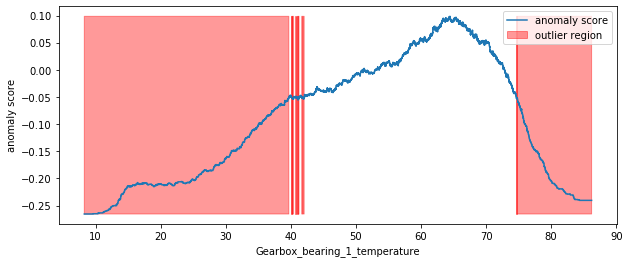

In [35]:
isolation_forest.fit(windfarm['Gb1t_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['Gb1t_avg'].min(), windfarm['Gb1t_avg'].max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Gearbox_bearing_1_temperature')
plt.show();

According to the above results and visualization, it seems that the Gearbox_bearing_1_temperature averages between 10 and 37 and 77 and 86 would be definitely considered as outliers.

There is another region with outliers that are not as obviously designated by the plot.

In [36]:
# # Visually investigate some of these anomalies
# Using Mask for Gearbox_bearing_1_temperature > 10 < 37, show first 5
windfarm[(windfarm.Gb1t_avg > 0) & (windfarm.Gb1t_avg < 37)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
13872,R80736,2016-11-26 19:30:00+00:00,2016-11-26,19:30:00,2016,11,90.0,90.0,90.0,0.0,16.040001,16.0,17.0,0.15,4.21,4.130000,4.28,0.030000,25.370001,24.980000,25.680000,0.12,-0.15,-0.44,0.00,0.08,0.0,0.00,0.00,0.00,0.15,0.00,0.44,0.08,1.0,1.0,1.0,0.0,0.000000,0.000000,0.00000,0.000000,19.889999,19.700001,19.900000,0.04,16.830000,16.799999,17.000000,0.06,21.549999,21.400000,21.600000,0.08,26.100000,26.000000,26.100000,0.01,26.700001,26.700001,26.799999,0.01,25.420000,24.799999,25.600000,0.22,29.200001,29.100000,29.299999,0.01,234.03,234.03,234.03,0.0,15.99,15.8,16.000000,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,133.67,123.090000,143.13000,5.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-100.370000,-110.940000,-90.900002,5.51,9.00,8.80,9.05,0.02,50.000000,49.959999,50.029999,0.01,695.89001,694.01001,698.37000,0.81,0.00,0.00,0.00,0.00,17.299999,17.299999,17.40,0.01,0.00000,0.00000,0.00,0.00,NaN,NaN,NaN,NaN,133.67,NaN,NaN,NaN,133.67,NaN,NaN,NaN
13875,R80736,2016-11-26 21:30:00+00:00,2016-11-26,21:30:00,2016,11,90.0,90.0,90.0,0.0,16.000000,16.0,16.0,0.00,4.07,4.030000,4.10,0.010000,24.190001,23.980000,24.360001,0.06,-0.13,-0.43,0.00,0.07,0.0,0.00,0.00,0.00,0.13,0.00,0.43,0.07,1.0,1.0,1.0,0.0,0.000000,0.000000,0.00000,0.000000,19.260000,19.100000,19.299999,0.07,16.200001,16.100000,16.200001,0.00,20.500000,20.400000,20.500000,0.01,25.299999,25.250000,25.500000,0.02,25.900000,25.850000,25.900000,0.01,24.570000,24.250000,24.799999,0.08,28.190001,28.100000,28.200001,0.02,234.03,234.03,234.03,0.0,15.83,15.8,16.000000,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,150.06,123.090000,205.46001,25.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-84.000000,-110.930000,-28.559999,25.15,8.66,8.50,8.75,0.07,50.020000,49.990002,50.040001,0.01,696.19000,693.65002,698.51001,1.47,0.00,0.00,0.00,0.00,17.000000,16.950001,17.00,0.00,0.00000,0.00000,0.00,0.00,NaN,NaN,NaN,NaN,150.06,NaN,NaN,NaN,150.06,NaN,NaN,NaN
13932,R80736,2016-11-14 21:00:00+00:00,2016-11-14,21:00:00,2016,11,45.0,45.0,45.0,0.0,9.000000,9.0,9.0,0.00,102.76,86.599998,126.43,12.240000,27.910000,27.719999,28.100000,0.07,-1.67,-2.07,-1.21,0.14,0.0,-0.13,0.07,0.01,1.67,1.21,2.07,0.14,1.0,1.0,1.0,0.0,98.739998,82.300003,122.52000,12.260000,21.610001,21.400000,21.700001,0.04,17.930000,17.700001,18.000000,0.06,25.309999,25.100000,25.600000,0.11,33.459999,33.400002,33.500000,0.04,32.720001,32.650002,32.900002,0.05,33.099998,33.000000,33.250000,0.02,34.099998,34.000000,34.299999,0.05,161.59,161.59,161.59,0.0,14.31,14.2,14.500000,0.05,1.50,0.00,2.64,0.72,2.39,1.54,3.07,0.28,1.95,0.87,2.84,0.45,180.41,144.429990,212.64000,10.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.790001,-17.150000,51.049999,10.64,-0.40,-0.45,-0.40,0.00,50.009998,50.000000,50.029999,0.01,707.56000,699.28998,709.79999,2.89,0.93,0.77,1.16,0.12,14.600000,14.500000,14.60,0.02,-164.00999,-235.17999,-112.77,22.25,NaN,NaN,NaN,NaN,180.41,NaN,Na

## Univariate Anomaly Detection on Gearbox_bearing_2_temperature

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

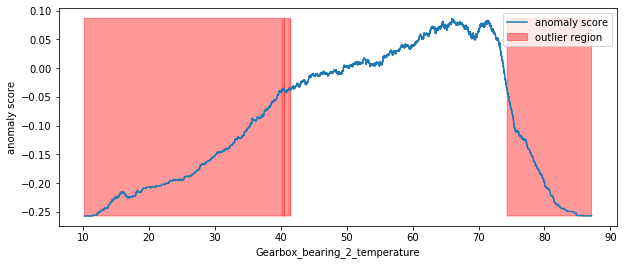

In [37]:
isolation_forest.fit(windfarm['Gb2t_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['Gb2t_avg'].min(), windfarm['Gb2t_avg'].max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Gearbox_bearing_2_temperature')
plt.show();

According to the above results and visualization, it seems that the Gearbox_bearing_2_temperature averages between 10 and 37 and 77 and 86 would be definitely considered as outliers.

In [38]:
# # Visually investigate some of these anomalies
# Using Mask for Gearbox_bearing_2_temperature > 10 < 37, show first 5
windfarm[(windfarm.Gb2t_avg > 0) & (windfarm.Gb2t_avg < 37)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
13872,R80736,2016-11-26 19:30:00+00:00,2016-11-26,19:30:00,2016,11,90.00,90.00,90.0,0.00,16.040001,16.0,17.0,0.15,4.21,4.130000,4.28000,0.03,25.370001,24.980000,25.680000,0.120000,-0.15,-0.44,0.000000,0.08,0.00,0.00,0.00,0.00,0.15,0.00,0.440000,0.08,1.0,1.0,1.0,0.0,0.000000,0.000000,0.00,0.00,19.889999,19.700001,19.900000,0.04,16.830000,16.799999,17.000000,0.06,21.549999,21.400000,21.600000,0.08,26.100000,26.000000,26.100000,0.01,26.700001,26.700001,26.799999,0.01,25.420000,24.799999,25.600000,0.22,29.200001,29.100000,29.299999,0.01,234.03000,234.03000,234.03000,0.0,15.99,15.8,16.000000,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,133.67000,123.090000,143.13000,5.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-100.370000,-110.940000,-90.900002,5.51,9.00,8.80,9.05,0.02,50.000000,49.959999,50.029999,0.01,695.89001,694.01001,698.37000,0.81,0.000000,0.00,0.00,0.00,17.299999,17.299999,17.40,0.01,0.00000,0.00000,0.00000,0.000000,NaN,NaN,NaN,NaN,133.67000,NaN,NaN,NaN,133.67000,NaN,NaN,NaN
13875,R80736,2016-11-26 21:30:00+00:00,2016-11-26,21:30:00,2016,11,90.00,90.00,90.0,0.00,16.000000,16.0,16.0,0.00,4.07,4.030000,4.10000,0.01,24.190001,23.980000,24.360001,0.060000,-0.13,-0.43,0.000000,0.07,0.00,0.00,0.00,0.00,0.13,0.00,0.430000,0.07,1.0,1.0,1.0,0.0,0.000000,0.000000,0.00,0.00,19.260000,19.100000,19.299999,0.07,16.200001,16.100000,16.200001,0.00,20.500000,20.400000,20.500000,0.01,25.299999,25.250000,25.500000,0.02,25.900000,25.850000,25.900000,0.01,24.570000,24.250000,24.799999,0.08,28.190001,28.100000,28.200001,0.02,234.03000,234.03000,234.03000,0.0,15.83,15.8,16.000000,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,150.06000,123.090000,205.46001,25.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-84.000000,-110.930000,-28.559999,25.15,8.66,8.50,8.75,0.07,50.020000,49.990002,50.040001,0.01,696.19000,693.65002,698.51001,1.47,0.000000,0.00,0.00,0.00,17.000000,16.950001,17.00,0.00,0.00000,0.00000,0.00000,0.000000,NaN,NaN,NaN,NaN,150.06000,NaN,NaN,NaN,150.06000,NaN,NaN,NaN
13932,R80736,2016-11-14 21:00:00+00:00,2016-11-14,21:00:00,2016,11,45.00,45.00,45.0,0.00,9.000000,9.0,9.0,0.00,102.76,86.599998,126.43000,12.24,27.910000,27.719999,28.100000,0.070000,-1.67,-2.07,-1.210000,0.14,0.00,-0.13,0.07,0.01,1.67,1.21,2.070000,0.14,1.0,1.0,1.0,0.0,98.739998,82.300003,122.52,12.26,21.610001,21.400000,21.700001,0.04,17.930000,17.700001,18.000000,0.06,25.309999,25.100000,25.600000,0.11,33.459999,33.400002,33.500000,0.04,32.720001,32.650002,32.900002,0.05,33.099998,33.000000,33.250000,0.02,34.099998,34.000000,34.299999,0.05,161.59000,161.59000,161.59000,0.0,14.31,14.2,14.500000,0.05,1.50,0.00,2.64,0.72,2.39,1.54,3.07,0.28,1.95,0.87,2.84,0.45,180.41000,144.429990,212.64000,10.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.790001,-17.150000,51.049999,10.64,-0.40,-0.45,-0.40,0.00,50.009998,50.000000,50.029999,0.01,707.56000,699.28998,709.79999,2.89,0.930000,0.77,1.16,0.1

## Univariate Anomaly Detection on Gearbox_inlet_temperature

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

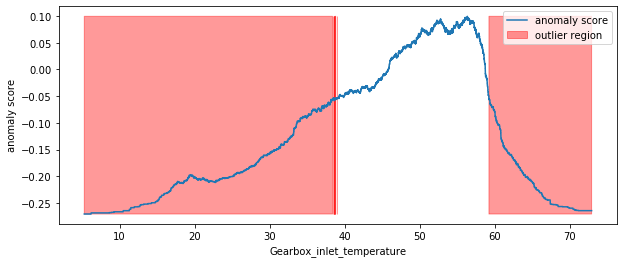

In [39]:
isolation_forest.fit(windfarm['Git_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['Git_avg'].min(), windfarm['Git_avg'].max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Gearbox_inlet_temperature')
plt.show();

According to the above results and visualization, it seems that the Gearbox_inlet_temperature averages between 10 and 34 and 60 and 70 would be definitely considered as outliers.

There is another region with outliers that is not as obviously designated by the plot.

In [40]:
# # Visually investigate some of these anomalies
# Using Mask for Gearbox_inlet_temperature > 10 < 60, show first 5
windfarm[(windfarm.Git_avg > 10) & (windfarm.Git_avg < 60)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
13872,R80736,2016-11-26 19:30:00+00:00,2016-11-26,19:30:00,2016,11,90.00,90.00,90.00,0.00,16.040001,16.0,17.00,0.15,4.21000,4.130000,4.28000,0.03,25.370001,24.980000,25.680000,0.120000,-0.15,-0.440000,0.000000,0.080000,0.000000,0.00,0.000000,0.00,0.15,0.000000,0.440000,0.08,1.00,1.00,1.00,0.00,0.000000,0.000000,0.00000,0.000000,19.889999,19.700001,19.900000,0.04,16.830000,16.799999,17.000000,0.06,21.549999,21.400000,21.600000,0.08,26.100000,26.000000,26.100000,0.01,26.700001,26.700001,26.799999,0.01,25.420000,24.799999,25.600000,0.22,29.200001,29.100000,29.299999,0.01,234.030000,234.030000,234.030000,0.0,15.990000,15.800000,16.000000,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,133.67,123.09,143.13000,5.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-100.37,-110.940000,-90.900002,5.51,9.00,8.8,9.05,0.02,50.00,49.959999,50.029999,0.01,695.89001,694.01001,698.37000,0.81,0.000000,0.00,0.00,0.00,17.299999,17.299999,17.400000,0.01,0.00000,0.00,0.000000,0.000000,NaN,NaN,NaN,NaN,133.67,NaN,NaN,NaN,133.67,NaN,NaN,NaN
13875,R80736,2016-11-26 21:30:00+00:00,2016-11-26,21:30:00,2016,11,90.00,90.00,90.00,0.00,16.000000,16.0,16.00,0.00,4.07000,4.030000,4.10000,0.01,24.190001,23.980000,24.360001,0.060000,-0.13,-0.430000,0.000000,0.070000,0.000000,0.00,0.000000,0.00,0.13,0.000000,0.430000,0.07,1.00,1.00,1.00,0.00,0.000000,0.000000,0.00000,0.000000,19.260000,19.100000,19.299999,0.07,16.200001,16.100000,16.200001,0.00,20.500000,20.400000,20.500000,0.01,25.299999,25.250000,25.500000,0.02,25.900000,25.850000,25.900000,0.01,24.570000,24.250000,24.799999,0.08,28.190001,28.100000,28.200001,0.02,234.030000,234.030000,234.030000,0.0,15.830000,15.800000,16.000000,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,150.06,123.09,205.46001,25.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-84.00,-110.930000,-28.559999,25.15,8.66,8.5,8.75,0.07,50.02,49.990002,50.040001,0.01,696.19000,693.65002,698.51001,1.47,0.000000,0.00,0.00,0.00,17.000000,16.950001,17.000000,0.00,0.00000,0.00,0.000000,0.000000,NaN,NaN,NaN,NaN,150.06,NaN,NaN,NaN,150.06,NaN,NaN,NaN
13878,R80736,2016-11-29 23:40:00+00:00,2016-11-29,23:40:00,2016,11,45.00,45.00,45.00,0.00,9.000000,9.0,9.94,0.05,94.43000,73.129997,107.93000,8.53,28.719999,28.450001,28.969999,0.080000,-1.31,-1.780000,-0.930000,0.140000,0.000000,0.00,0.090000,0.00,1.31,0.930000,1.780000,0.14,1.00,1.00,1.00,0.00,90.470001,68.980003,104.04000,8.520001,41.369999,41.200001,41.599998,0.12,35.139999,34.900002,35.500000,0.14,54.889999,54.599998,55.400002,0.21,46.560001,46.400002,46.599998,0.07,47.500000,47.299999,47.700001,0.14,47.549999,47.200001,47.900002,0.15,49.990002,49.799999,50.200001,0.10,81.459999,81.459999,81.459999,0.0,21.459999,21.200001,21.600000,0.06,0.34,0.00,1.96,0.68,2.32,1.73,2.76,0.22,1.33,0.86,2.36,0.39,125.34,106.24,141.37000,5.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.91,24.780001,59.910000,5.32,0.07,-0.1,0.20,0.11,49.98,49.950

## Univariate Anomaly Detection on Gearbox_oil_sump_temperature

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

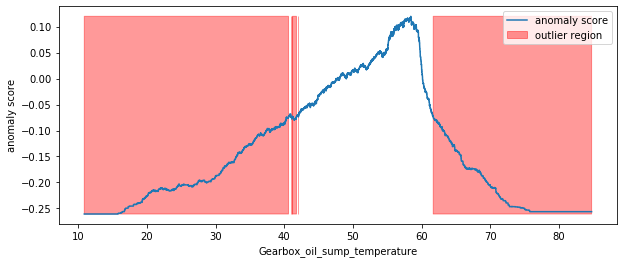

In [41]:
isolation_forest.fit(windfarm['Gost_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['Gost_avg'].min(), windfarm['Gost_avg'].max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Gearbox_oil_sump_temperature')
plt.show();

According to the above results and visualization, it seems that the Gearbox_oil_sump_temperature averages between 15 and 37 and 64 and 84 would be definitely considered as outliers.

There is another region with outliers that is not as obviously designated by the plot.

In [42]:
# # Visually investigate some of these anomalies
# Using Mask for Gearbox_oil_sump_temperature > 15 < 37, show first 5
windfarm[(windfarm.Gost_avg > 15) & (windfarm.Gost_avg < 37)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
13872,R80736,2016-11-26 19:30:00+00:00,2016-11-26,19:30:00,2016,11,90.00,90.00,90.0,0.00,16.040001,16.0,17.0,0.15,4.21,4.130000,4.28000,0.030000,25.370001,24.980000,25.680000,0.120000,-0.15,-0.44,0.000000,0.08,0.00,0.00,0.00,0.00,0.15,0.00,0.440000,0.08,1.0,1.0,1.0,0.0,0.000000,0.000000,0.00000,0.000000,19.889999,19.700001,19.900000,0.04,16.830000,16.799999,17.000000,0.06,21.549999,21.4,21.600000,0.08,26.100000,26.000000,26.100000,0.01,26.700001,26.700001,26.799999,0.01,25.420000,24.799999,25.600000,0.22,29.200001,29.100000,29.299999,0.01,234.03000,234.03000,234.03000,0.0,15.99,15.8,16.0,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,133.67000,123.09000,143.13000,5.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-100.370000,-110.940000,-90.900002,5.51,9.00,8.80,9.05,0.02,50.000000,49.959999,50.029999,0.01,695.89001,694.01001,698.37000,0.81,0.000000,0.00,0.00,0.00,17.299999,17.299999,17.4,0.01,0.00000,0.00000,0.00000,0.000000,NaN,NaN,NaN,NaN,133.67000,NaN,NaN,NaN,133.67000,NaN,NaN,NaN
13875,R80736,2016-11-26 21:30:00+00:00,2016-11-26,21:30:00,2016,11,90.00,90.00,90.0,0.00,16.000000,16.0,16.0,0.00,4.07,4.030000,4.10000,0.010000,24.190001,23.980000,24.360001,0.060000,-0.13,-0.43,0.000000,0.07,0.00,0.00,0.00,0.00,0.13,0.00,0.430000,0.07,1.0,1.0,1.0,0.0,0.000000,0.000000,0.00000,0.000000,19.260000,19.100000,19.299999,0.07,16.200001,16.100000,16.200001,0.00,20.500000,20.4,20.500000,0.01,25.299999,25.250000,25.500000,0.02,25.900000,25.850000,25.900000,0.01,24.570000,24.250000,24.799999,0.08,28.190001,28.100000,28.200001,0.02,234.03000,234.03000,234.03000,0.0,15.83,15.8,16.0,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,150.06000,123.09000,205.46001,25.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-84.000000,-110.930000,-28.559999,25.15,8.66,8.50,8.75,0.07,50.020000,49.990002,50.040001,0.01,696.19000,693.65002,698.51001,1.47,0.000000,0.00,0.00,0.00,17.000000,16.950001,17.0,0.00,0.00000,0.00000,0.00000,0.000000,NaN,NaN,NaN,NaN,150.06000,NaN,NaN,NaN,150.06000,NaN,NaN,NaN
13932,R80736,2016-11-14 21:00:00+00:00,2016-11-14,21:00:00,2016,11,45.00,45.00,45.0,0.00,9.000000,9.0,9.0,0.00,102.76,86.599998,126.43000,12.240000,27.910000,27.719999,28.100000,0.070000,-1.67,-2.07,-1.210000,0.14,0.00,-0.13,0.07,0.01,1.67,1.21,2.070000,0.14,1.0,1.0,1.0,0.0,98.739998,82.300003,122.52000,12.260000,21.610001,21.400000,21.700001,0.04,17.930000,17.700001,18.000000,0.06,25.309999,25.1,25.600000,0.11,33.459999,33.400002,33.500000,0.04,32.720001,32.650002,32.900002,0.05,33.099998,33.000000,33.250000,0.02,34.099998,34.000000,34.299999,0.05,161.59000,161.59000,161.59000,0.0,14.31,14.2,14.5,0.05,1.50,0.00,2.64,0.72,2.39,1.54,3.07,0.28,1.95,0.87,2.84,0.45,180.41000,144.42999,212.64000,10.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.790001,-17.150000,51.049999,10.64,-0.40,-0.45,-0.40,0.00,50.009998,50.000000,50.029999,0.01,707.56000,699.28998,709.79999,2.89,0.930000,0.77,1.16,0.12,

## Univariate Anomaly Detection on Nacelle_angle_corrected

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

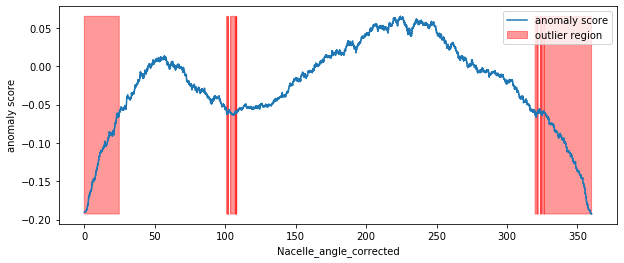

In [43]:
isolation_forest.fit(windfarm['Na_c_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['Na_c_avg'].dropna().min(), windfarm['Na_c_avg'].dropna().max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Nacelle_angle_corrected')
plt.show();

According to the above results and visualization, it seems that the Nacelle_angle_corrected averages between 0 and 35 and 305 and 350 would be definitely considered as outliers.

In [44]:
# # Visually investigate some of these anomalies
# Using Mask for Nacelle_angle_corrected > 0 < 35, show first 5
windfarm[(windfarm.Na_c_avg > 0) & (windfarm.Na_c_avg < 35)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
13954,R80736,2016-12-03 07:30:00+00:00,2016-12-03,07:30:00,2016,12,-0.99,-0.99,-0.99,0.00,12.07,12.0,13.000000,0.20,1792.36000,1653.89000,1819.15000,31.629999,5231.02980,3260.220000,7746.529800,1004.090000,977.46997,558.31,1455.130000,196.679990,54.610001,38.680000,72.070000,6.87,979.09998,561.47998,1456.11000,196.320010,1.00,1.0,0.99,0.0,1789.60000,1651.09000,1816.28000,31.650000,43.990002,43.299999,44.700001,0.30,34.730000,34.500000,34.950001,0.10,60.959999,59.549999,62.150002,0.45,68.790001,68.300003,69.199997,0.22,72.800003,72.500000,73.000000,0.08,50.470001,50.099998,51.200001,0.19,57.549999,57.150002,57.849998,0.16,38.660000,38.660000,38.660000,0.0,20.670000,20.500000,20.900000,0.12,7.88,4.88,11.16,1.08,7.84,5.54,11.14,0.98,7.86,5.56,11.14,0.99,34.980000,12.73000,73.480003,9.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.70000,-25.930000,34.820000,9.34,1.47,1.3,1.5,0.06,49.990002,49.970001,50.009998,0.01,697.71002,695.77002,699.02002,0.62,17.080000,15.74,17.340000,0.30,24.350000,24.299999,24.400000,0.04,5205.0801,3216.370100,7709.37010,1004.650000,NaN,NaN,NaN,NaN,34.980000,NaN,NaN,NaN,34.980000,NaN,NaN,NaN
13974,R80736,2016-11-27 14:50:00+00:00,2016-11-27,14:50:00,2016,11,-0.99,-0.99,-0.99,0.00,16.00,16.0,16.000000,0.00,1338.33000,1229.43010,1486.59000,65.449997,2126.92990,1735.340000,2705.870100,230.030000,272.79999,190.70,397.290010,50.209999,31.110001,21.980000,39.849998,3.60,274.70999,193.48000,398.14001,49.700001,0.99,1.0,0.98,0.0,1335.05000,1226.23000,1483.33000,65.449997,42.750000,42.299999,43.299999,0.14,40.939999,40.099998,41.700001,0.39,56.340000,55.150002,57.599998,0.36,62.320000,60.700001,63.750000,0.85,66.769997,65.500000,67.900002,0.67,49.619999,48.250000,50.700001,0.42,56.240002,55.250000,57.200001,0.49,11.220000,11.220000,11.220000,0.0,23.360001,22.799999,24.000000,0.33,5.67,4.14,7.59,0.63,5.54,4.24,7.59,0.62,5.61,4.20,7.53,0.59,11.200000,328.98001,57.470001,12.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.08000,-42.240002,46.250000,12.45,7.32,7.2,7.4,0.04,49.970001,49.950001,50.000000,0.01,704.37000,703.25000,705.17999,0.30,12.720000,11.67,14.150000,0.63,26.400000,26.350000,26.400000,0.01,1939.0000,1461.340000,2576.66990,260.310000,NaN,NaN,NaN,NaN,11.200000,NaN,NaN,NaN,11.200000,NaN,NaN,NaN
14005,R80736,2016-08-06 23:40:00+00:00,2016-08-06,23:40:00,2016,8,0.08,0.00,0.50,0.18,26.01,26.0,26.969999,0.09,973.17999,971.95001,975.47998,0.580000,397.45999,231.110000,569.539980,94.709999,11.00000,-2.35,28.879999,8.860000,2.560000,-0.790000,10.730000,3.20,11.74000,0.25000,30.67000,9.000000,1.00,1.0,1.00,0.0,969.95001,968.59003,972.08002,0.570000,41.759998,40.849998,42.700001,0.43,39.349998,38.700001,40.000000,0.28,59.009998,57.450001,60.700001,0.58,61.700001,61.400002,61.900002,0.10,60.340000,60.200001,60.700001,0.10,56.860001,56.599998,57.150002,0.11,58.250000,58.049999,58.349998,0.06,9.030000,9.030000,9.030000,0.0,32.439999,32.000000,32.799999,0.21,2

## Univariate Anomaly Detection on Grid_frequency

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

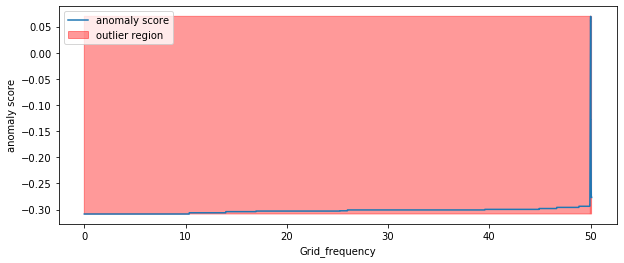

In [45]:
isolation_forest.fit(windfarm['Nf_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['Nf_avg'].dropna().min(), windfarm['Nf_avg'].dropna().max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Grid_frequency')
plt.show();

Everything in the Grid_frequency column is an outlier? How is that possible?

In [46]:
windfarm['Nf_avg'].dropna().value_counts()

50.000000    97259
49.990002    73398
49.980000    72672
50.009998    35069
49.990000    35051
49.970001    22689
50.020000    22539
50.010000    17351
49.970000    10958
49.959999     8981
50.029999     6393
49.960000     4232
49.950001     3705
50.030000     2934
50.040001     2324
49.950000     1945
49.939999     1755
50.040000     1274
50.049999     1043
49.930000      894
49.940000      712
50.050000      604
50.060001      369
50.060000      295
50.070000      195
49.919998      179
49.920000       68
49.910000       53
0.000000        48
50.080002       28
50.080000       20
49.900000       12
50.090000        4
49.889999        4
15.480000        2
28.450001        2
46.650002        2
45.400002        1
6.820000         1
6.130000         1
11.000000        1
22.870001        1
10.440000        1
21.730000        1
26.360001        1
5.950000         1
8.120000         1
4.940000         1
28.400000        1
6.880000         1
8.500000         1
25.420000        1
28.770000   

## Univariate Anomaly Detection on Grid voltage

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

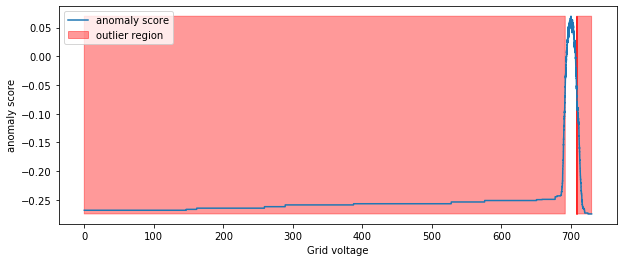

In [47]:
isolation_forest.fit(windfarm['Nu_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['Nu_avg'].dropna().min(), windfarm['Nu_avg'].dropna().max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Grid voltage')
plt.show();

Almost everything in the Grid_voltage column is an outlier? Except around 700?

In [48]:
windfarm['Nu_avg'].dropna().value_counts()

699.87000    377
699.56000    373
701.06000    368
699.69000    366
698.94000    365
            ... 
717.74000      1
717.40997      1
714.01000      1
718.82000      1
718.09998      1
Name: Nu_avg, Length: 6311, dtype: int64

## Univariate Anomaly Detection on Outdoor Temperature average

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

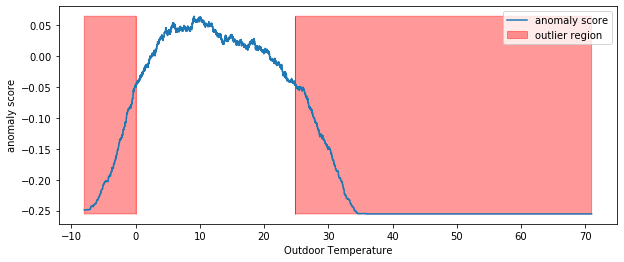

In [49]:
isolation_forest.fit(windfarm['Ot_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['Ot_avg'].min(), windfarm['Ot_avg'].max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Outdoor Temperature')
plt.show();

According to the above results and visualization, it seems that the Outdoor Temperature averages between -8 and -1 and 25 and 70+ * C would be definitely considered as outliers.

In [50]:
# # Visually investigate some of these anomalies
# Using Mask for Outdoor Temperature > -8 < -1, show first 5
windfarm[(windfarm.Ot_avg > -8) & (windfarm.Ot_avg < -1)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
13920,R80736,2016-12-04 05:20:00+00:00,2016-12-04,05:20:00,2016,12,-0.99,-0.99,-0.99,0.0,10.00,10.0,10.06,0.00,1348.28,1314.66,1370.2200,11.110000,2220.3201,2091.2100,2343.73,43.98000,288.32001,262.28000,307.89999,8.820000,36.560001,28.059999,40.209999,1.71,290.67001,264.92001,310.12000,8.710000,0.99,0.99,0.99,0.00,1345.11,1311.39,1367.02,11.120000,39.540001,38.799999,40.299999,0.27,30.959999,30.600000,31.299999,0.14,54.060001,52.900002,55.349998,0.38,65.510002,65.099998,65.849998,0.18,68.680000,68.300003,68.900002,0.15,57.590000,57.200001,57.950001,0.15,59.000000,58.700001,59.299999,0.11,50.730000,50.730000,50.730000,0.0,22.370001,22.000000,22.600000,0.16,5.51,4.20,6.97,0.52,5.99,4.72,7.22,0.46,5.75,4.52,7.10,0.45,59.180000,23.290001,82.599998,9.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.479999,-27.440001,31.870001,9.03,-1.75,-1.80,-1.6,0.07,50.000000,49.970001,50.009998,0.01,697.46997,695.78003,699.29999,0.67,12.82,12.49,13.04,0.11,21.940001,21.799999,22.000000,0.07,2046.5000,1909.5601,2150.7000,46.189999,NaN,NaN,NaN,NaN,59.180000,NaN,NaN,NaN,59.180000,NaN,NaN,NaN
13981,R80736,2016-12-04 04:20:00+00:00,2016-12-04,04:20:00,2016,12,-0.99,-0.99,-0.99,0.0,10.00,10.0,10.18,0.01,1179.03,1164.35,1209.7100,7.280000,1685.1400,1610.6801,1776.75,28.35000,175.14000,165.75999,195.69000,4.640000,28.940001,22.400000,33.299999,1.67,177.57001,167.52000,198.00000,4.600000,0.98,0.99,0.98,0.00,1175.79,1161.36,1206.42,7.290000,36.130001,34.099998,38.400002,1.22,28.879999,27.799999,30.400000,0.76,55.689999,53.000000,58.349998,1.32,61.680000,61.099998,62.049999,0.19,65.699997,65.300003,66.000000,0.18,55.529999,55.250000,55.849998,0.09,57.910000,57.650002,58.099998,0.10,50.730000,50.730000,50.730000,0.0,7.970000,6.500000,12.500000,1.67,4.93,3.50,6.22,0.47,5.43,4.13,7.10,0.44,5.18,3.91,6.54,0.41,57.660000,13.650000,117.450000,10.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.980000,-37.080002,66.720001,10.92,-1.80,-1.85,-1.6,0.02,49.980000,49.959999,50.000000,0.01,699.32001,697.34003,701.32001,0.58,11.19,11.04,11.50,0.07,21.500000,21.299999,21.600000,0.05,1422.2500,1353.4600,1548.7500,28.889999,NaN,NaN,NaN,NaN,57.660000,NaN,NaN,NaN,57.660000,NaN,NaN,NaN
14161,R80736,2016-11-29 06:40:00+00:00,2016-11-29,06:40:00,2016,11,-0.99,-0.99,-0.99,0.0,8.92,8.0,9.00,0.21,1243.45,1112.91,1421.8800,78.879997,1884.3101,1410.5601,2517.75,271.14001,218.59000,134.07001,353.72000,53.560001,72.389999,54.810001,91.269997,7.37,231.00000,150.58000,360.60001,50.990002,0.94,0.98,0.86,0.03,1240.16,1109.55,1418.74,78.919998,43.360001,42.900002,44.000000,0.20,33.070000,32.700001,33.400002,0.12,59.490002,58.549999,60.900002,0.38,62.919998,62.250000,63.599998,0.40,65.010002,63.500000,66.500000,0.96,55.320000,54.900002,56.000000,0.21,57.070000,56.500000,57.400002,0.14,44.150002,44.150002,44.150002,0.0,23.299999,23.100000,23.600000,0.16,5.10,3.21,7.38,0.68,5.34,3.92,7.26,0.55,5.22,3.60,7.28,0.59,39.110001,323.870000,12

## Univariate Anomaly Detection on Active_power

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


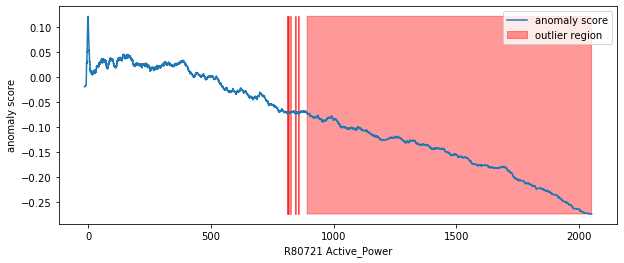

In [16]:
isolation_forest.fit(wf_R80721['P_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(wf_R80721['P_avg'].min(), wf_R80721['P_avg'].max(), len(wf_R80721)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('R80721 Active_Power')
plt.show();

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


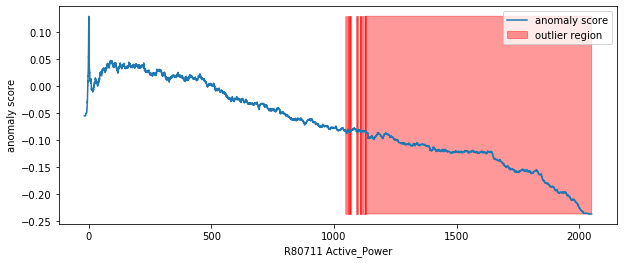

In [17]:
isolation_forest.fit(wf_R80711['P_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(wf_R80711['P_avg'].min(), wf_R80711['P_avg'].max(), len(wf_R80711)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('R80711 Active_Power')
plt.show();

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


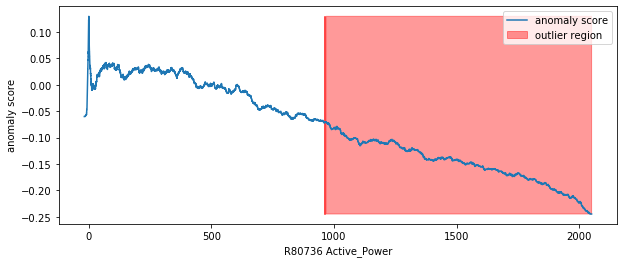

In [18]:
isolation_forest.fit(wf_R80736['P_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(wf_R80736['P_avg'].min(), wf_R80736['P_avg'].max(), len(wf_R80736)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('R80736 Active_Power')
plt.show();

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


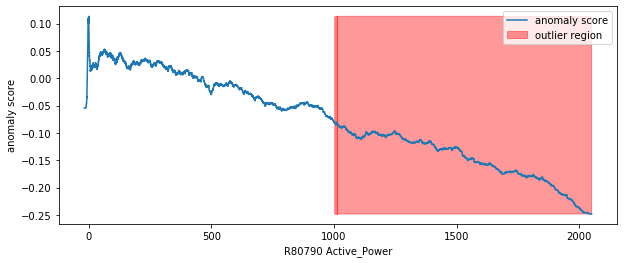

In [19]:
isolation_forest.fit(wf_R80790['P_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(wf_R80790['P_avg'].min(), wf_R80790['P_avg'].max(), len(wf_R80790)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('R80790 Active_Power')
plt.show();

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

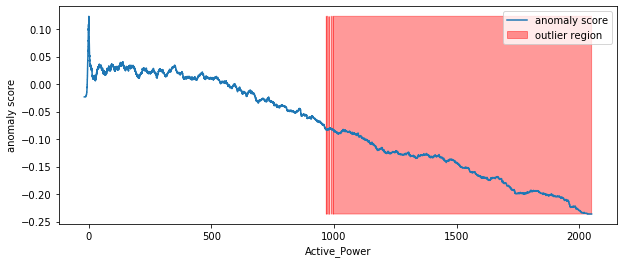

In [51]:
isolation_forest.fit(windfarm['P_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['P_avg'].min(), windfarm['P_avg'].max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Active_Power')
plt.show();

According to the above results and visualization, it seems that the Active_Power averages greater than 1250 would be definitely considered as outliers.

There is another region with outliers that is not as obviously designated by the plot.

In [52]:
# # Visually investigate some of these anomalies
# Using Mask for Active_Power > 1250, show first 5
windfarm[(windfarm.P_avg > 1250)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
14092,R80736,2016-11-25 03:50:00+00:00,2016-11-25,03:50:00,2016,11,9.54,1.71,15.47,3.04,17.0,17.0,17.0,0.0,1804.1400,1766.3700,1878.9399,20.370001,10954.8000,10744.3000,11006.3,23.280001,2050.0901,1974.21,2136.4800,24.35000,181.840000,171.96001,188.48,2.370000,2058.1399,1982.68010,2144.0801,24.209999,0.99,1.0,0.99,0.0,1800.6801,1762.78,1875.4301,20.360001,34.900002,34.599998,35.250000,0.10,35.689999,35.299999,36.049999,0.16,75.989998,74.699997,77.099998,0.41,69.919998,69.599998,70.250000,0.16,72.209999,72.099998,72.400002,0.03,47.869999,46.049999,50.349998,1.02,57.020000,56.650002,57.250000,0.10,55.119999,55.119999,55.119999,0.00,13.760000,13.5,14.000000,0.09,15.25,9.450000,20.049999,2.02,14.14,9.13,18.910000,1.72,14.70,9.290000,19.120001,1.84,51.169998,24.719999,81.400002,6.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.95,-30.400000,26.280001,6.32,7.690000,7.6,7.7,0.02,49.980000,49.959999,50.000000,0.01,711.69000,709.34003,714.00000,0.76,17.190001,16.830000,17.900000,0.20,27.180000,27.000000,27.200001,0.05,10871.9000,10641.1000,10910.8,22.02000,NaN,NaN,NaN,NaN,51.169998,NaN,NaN,NaN,51.169998,NaN,NaN,NaN
14094,R80736,2016-08-02 07:50:00+00:00,2016-08-02,07:50:00,2016,8,0.80,-0.99,6.24,2.03,26.0,26.0,26.0,0.0,1800.4301,1776.5100,1852.9301,12.810000,9253.9004,4365.2798,10999.2,1658.630000,1726.8000,810.19,2108.9299,309.88000,73.839996,27.23000,108.26,17.459999,1728.5699,814.26001,2110.1001,309.310000,1.00,1.0,0.99,0.0,1796.5699,1772.66,1849.0601,12.800000,36.759998,36.400002,37.200001,0.12,36.549999,36.349998,36.700001,0.08,63.689999,61.200001,67.050003,1.57,70.220001,68.800003,71.250000,0.69,72.220001,72.000000,72.400002,0.10,50.700001,49.950001,51.500000,0.36,56.840000,56.299999,57.500000,0.31,227.440000,227.440000,227.440000,0.00,22.620001,22.5,22.799999,0.06,11.63,6.160000,15.610000,1.71,10.93,6.15,14.360000,1.46,11.28,6.170000,14.850000,1.56,222.270000,194.830000,266.380000,8.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.19,-32.610001,38.939999,8.22,18.629999,18.1,19.0,0.22,49.990002,49.959999,50.020000,0.01,703.27002,701.14001,704.79999,0.73,17.150000,16.910000,17.670000,0.12,34.610001,34.599998,34.799999,0.02,9177.4199,4335.7900,10899.0,1639.23000,NaN,NaN,NaN,NaN,222.270000,NaN,NaN,NaN,222.270000,NaN,NaN,NaN
14109,R80736,2016-11-28 10:10:00+00:00,2016-11-28,10:10:00,2016,11,4.92,-0.99,14.00,4.54,13.0,13.0,13.0,0.0,1803.3800,1764.3800,1885.8600,18.459999,10297.8000,5741.5601,11008.5,1173.330000,1927.4301,1067.49,2145.8401,222.67999,168.740010,135.41000,187.45,12.810000,1934.9399,1079.55000,2153.1699,221.850010,0.99,1.0,0.99,0.0,1800.0699,1761.03,1882.5000,18.459999,28.020000,27.600000,28.450001,0.19,26.590000,26.450001,26.750000,0.08,61.939999,60.400002,63.849998,0.85,67.540001,66.900002,68.099998,0.27,70.529999,70.300003,70.800003,0.11,42.599998,41.450001,44.049999,0.62,53.549999,53.250000,53.950001,0.14,50.560001,40.860001,50.730000,1.07,9.750000,9.5,10.00000

## No Univariate Anomaly Detection on Pitch_angle_setpoint

In [53]:
windfarm['Pas_avg'].value_counts()

Series([], Name: Pas_avg, dtype: int64)

## Univariate Anomaly Detection on Rotor_bearing_temperature

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

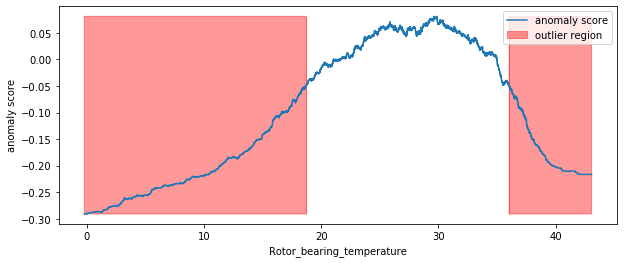

In [54]:
isolation_forest.fit(windfarm['Rbt_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['Rbt_avg'].min(), windfarm['Rbt_avg'].max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Rotor_bearing_temperature')
plt.show();

According to the above results and visualization, it seems that the Rotor_bearing_temperature averages between 0 and 18 and 27 and 42 would be definitely considered as outliers.

In [55]:
# # Visually investigate some of these anomalies
# Using Mask for Rotor_bearing_temperature > 0 and < 18, show first 5
windfarm[(windfarm.Rbt_avg > 0) & (windfarm.Rbt_avg < 18)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
13872,R80736,2016-11-26 19:30:00+00:00,2016-11-26,19:30:00,2016,11,90.0,90.0,90.0,0.0,16.040001,16.0,17.0,0.15,4.21,4.130000,4.280000,0.03,25.370001,24.980000,25.680000,0.12,-0.15,-0.44,0.00,0.08,0.0,0.00,0.00,0.00,0.15,0.00,0.44,0.08,1.0,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.00,19.889999,19.700001,19.900000,0.04,16.830000,16.799999,17.000000,0.06,21.549999,21.400000,21.600000,0.08,26.100000,26.000000,26.100000,0.01,26.700001,26.700001,26.799999,0.01,25.420000,24.799999,25.600000,0.22,29.200001,29.100000,29.299999,0.01,234.03,234.03,234.03,0.0,15.990000,15.8,16.000000,0.03,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,133.67000,123.09000,143.13000,5.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-100.370000,-110.940000,-90.900002,5.51,9.00,8.80,9.05,0.02,50.000000,49.959999,50.029999,0.01,695.89001,694.01001,698.37000,0.81,0.00,0.00,0.00,0.00,17.299999,17.299999,17.400000,0.01,0.00000,0.00000,0.00,0.00,NaN,NaN,NaN,NaN,133.67000,NaN,NaN,NaN,133.67000,NaN,NaN,NaN
13875,R80736,2016-11-26 21:30:00+00:00,2016-11-26,21:30:00,2016,11,90.0,90.0,90.0,0.0,16.000000,16.0,16.0,0.00,4.07,4.030000,4.100000,0.01,24.190001,23.980000,24.360001,0.06,-0.13,-0.43,0.00,0.07,0.0,0.00,0.00,0.00,0.13,0.00,0.43,0.07,1.0,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.00,19.260000,19.100000,19.299999,0.07,16.200001,16.100000,16.200001,0.00,20.500000,20.400000,20.500000,0.01,25.299999,25.250000,25.500000,0.02,25.900000,25.850000,25.900000,0.01,24.570000,24.250000,24.799999,0.08,28.190001,28.100000,28.200001,0.02,234.03,234.03,234.03,0.0,15.830000,15.8,16.000000,0.07,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,150.06000,123.09000,205.46001,25.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-84.000000,-110.930000,-28.559999,25.15,8.66,8.50,8.75,0.07,50.020000,49.990002,50.040001,0.01,696.19000,693.65002,698.51001,1.47,0.00,0.00,0.00,0.00,17.000000,16.950001,17.000000,0.00,0.00000,0.00000,0.00,0.00,NaN,NaN,NaN,NaN,150.06000,NaN,NaN,NaN,150.06000,NaN,NaN,NaN
13893,R80736,2016-11-30 09:20:00+00:00,2016-11-30,09:20:00,2016,11,45.0,45.0,45.0,0.0,11.000000,11.0,11.0,0.00,4.66,4.630000,4.700000,0.01,28.219999,28.030001,28.420000,0.07,-0.47,-1.98,-0.06,0.48,0.0,0.00,0.13,0.01,0.47,0.06,1.98,0.48,1.0,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.00,31.680000,31.500000,31.799999,0.10,30.040001,29.799999,30.400000,0.15,53.020000,52.700001,53.299999,0.21,37.820000,37.400002,38.200001,0.18,40.759998,40.400002,41.099998,0.14,28.090000,26.000000,37.700001,2.44,44.020000,43.700001,44.599998,0.19,185.73,185.73,185.73,0.0,14.150000,13.7,14.600000,0.26,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,271.34000,234.42999,297.75000,14.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.610001,48.700001,112.020000,14.21,4.21,3.60,5.00,0.34,49.990002,49.950001,50.020000,0.02,700.40997,698.78998,702.40997,0.65,0.00,0.00,0.00,0.00,17.540001,17.299999,17.600000,0.05,0.00000,0.00000,0.00,0.00,NaN,NaN,NaN,NaN,271.3400

## Univariate Anomaly Detection on Torque

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

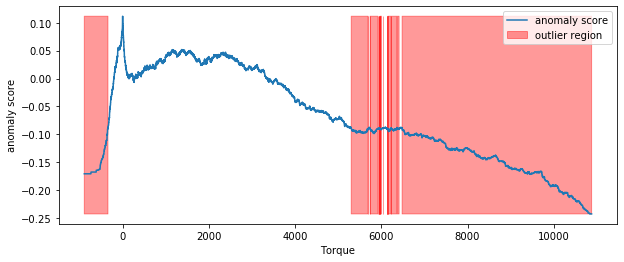

In [56]:
isolation_forest.fit(windfarm['Rm_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['Rm_avg'].dropna().min(), windfarm['Rm_avg'].dropna().max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Torque')
plt.show();

According to the above results and visualization, it seems that the Torque averages greater than 7000 would be definitely considered as outliers.

There are other regions with outliers that are not as obviously designated by the plot.

In [57]:
# # Visually investigate some of these anomalies
# Using Mask for Torque > 7000, show first 5
windfarm[(windfarm.Rm_avg > 7000)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
14092,R80736,2016-11-25 03:50:00+00:00,2016-11-25,03:50:00,2016,11,9.54,1.71,15.47,3.04,17.0,17.0,17.0,0.0,1804.1400,1766.3700,1878.9399,20.370001,10954.8000,10744.3000,11006.3,23.280001,2050.0901,1974.21,2136.4800,24.35000,181.840000,171.96001,188.48,2.370000,2058.1399,1982.68010,2144.0801,24.209999,0.99,1.0,0.99,0.0,1800.6801,1762.78,1875.4301,20.360001,34.900002,34.599998,35.250000,0.10,35.689999,35.299999,36.049999,0.16,75.989998,74.699997,77.099998,0.41,69.919998,69.599998,70.250000,0.16,72.209999,72.099998,72.400002,0.03,47.869999,46.049999,50.349998,1.02,57.020000,56.650002,57.250000,0.10,55.119999,55.119999,55.119999,0.00,13.760000,13.5,14.000000,0.09,15.25,9.450000,20.049999,2.02,14.14,9.13,18.910000,1.72,14.70,9.290000,19.120001,1.84,51.169998,24.719999,81.400002,6.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.95,-30.400000,26.280001,6.32,7.690000,7.6,7.7,0.02,49.980000,49.959999,50.000000,0.01,711.69000,709.34003,714.00000,0.76,17.190001,16.830000,17.900000,0.20,27.180000,27.000000,27.200001,0.05,10871.9000,10641.1000,10910.8,22.02000,NaN,NaN,NaN,NaN,51.169998,NaN,NaN,NaN,51.169998,NaN,NaN,NaN
14094,R80736,2016-08-02 07:50:00+00:00,2016-08-02,07:50:00,2016,8,0.80,-0.99,6.24,2.03,26.0,26.0,26.0,0.0,1800.4301,1776.5100,1852.9301,12.810000,9253.9004,4365.2798,10999.2,1658.630000,1726.8000,810.19,2108.9299,309.88000,73.839996,27.23000,108.26,17.459999,1728.5699,814.26001,2110.1001,309.310000,1.00,1.0,0.99,0.0,1796.5699,1772.66,1849.0601,12.800000,36.759998,36.400002,37.200001,0.12,36.549999,36.349998,36.700001,0.08,63.689999,61.200001,67.050003,1.57,70.220001,68.800003,71.250000,0.69,72.220001,72.000000,72.400002,0.10,50.700001,49.950001,51.500000,0.36,56.840000,56.299999,57.500000,0.31,227.440000,227.440000,227.440000,0.00,22.620001,22.5,22.799999,0.06,11.63,6.160000,15.610000,1.71,10.93,6.15,14.360000,1.46,11.28,6.170000,14.850000,1.56,222.270000,194.830000,266.380000,8.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.19,-32.610001,38.939999,8.22,18.629999,18.1,19.0,0.22,49.990002,49.959999,50.020000,0.01,703.27002,701.14001,704.79999,0.73,17.150000,16.910000,17.670000,0.12,34.610001,34.599998,34.799999,0.02,9177.4199,4335.7900,10899.0,1639.23000,NaN,NaN,NaN,NaN,222.270000,NaN,NaN,NaN,222.270000,NaN,NaN,NaN
14109,R80736,2016-11-28 10:10:00+00:00,2016-11-28,10:10:00,2016,11,4.92,-0.99,14.00,4.54,13.0,13.0,13.0,0.0,1803.3800,1764.3800,1885.8600,18.459999,10297.8000,5741.5601,11008.5,1173.330000,1927.4301,1067.49,2145.8401,222.67999,168.740010,135.41000,187.45,12.810000,1934.9399,1079.55000,2153.1699,221.850010,0.99,1.0,0.99,0.0,1800.0699,1761.03,1882.5000,18.459999,28.020000,27.600000,28.450001,0.19,26.590000,26.450001,26.750000,0.08,61.939999,60.400002,63.849998,0.85,67.540001,66.900002,68.099998,0.27,70.529999,70.300003,70.800003,0.11,42.599998,41.450001,44.049999,0.62,53.549999,53.250000,53.950001,0.14,50.560001,40.860001,50.730000,1.07,9.750000,9.5,10.00000

## Univariate Anomaly Detection on Rotor_speed  

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

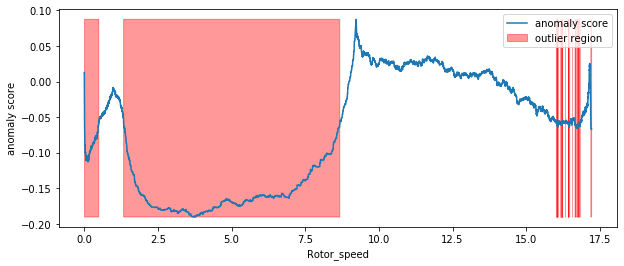

In [58]:
isolation_forest.fit(windfarm['Rs_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['Rs_avg'].dropna().min(), windfarm['Rs_avg'].dropna().max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Rotor_speed')
plt.show();

According to the above results and visualization, it seems that the Rotor_speed averages between 1.5 and 8 would be definitely considered as outliers.

There are other regions with outliers that are not as obviously designated by the plot.

In [59]:
# # Visually investigate some of these anomalies
# Using Mask for Rotor_speed between 1.5 and 8, show first 5
windfarm[(windfarm.Rs_avg > 1.5) & (windfarm.Rs_avg < 8)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
13998,R80736,2016-05-07 10:40:00+00:00,2016-05-07,10:40:00,2016,5,27.950001,-0.99,45.0,21.530001,26.48,26.0,28.00,0.47,466.82999,105.410000,983.09003,401.67001,108.150000,-67.489998,891.599980,169.600010,-2.330000,-33.840000,56.939999,11.92,3.56,-2.34,27.920000,6.660000,8.520001,0.39,61.59000,11.63,1.0,-1.0,0.90,0.01,463.35999,102.170000,979.38000,401.51999,45.750000,45.000000,46.200001,0.23,42.689999,42.200001,43.099998,0.26,60.230000,58.700001,61.099998,0.40,57.470001,55.900002,58.599998,0.93,55.660000,54.799999,56.299999,0.44,52.000000,51.650002,52.450001,0.15,52.560001,52.299999,52.799999,0.12,102.43,83.660004,111.10,12.360000,35.860001,35.700001,36.099998,0.09,3.47,0.92,5.73,0.81,3.26,0.85,5.41,0.77,3.37,1.01,5.57,0.76,77.059998,345.510010,210.74001,161.910000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.60,-125.590000,99.650002,167.789990,24.059999,23.60,24.400000,0.17,50.000000,49.970001,50.020000,0.01,696.40002,694.83002,697.82001,0.56,4.41,0.97,9.33,3.82,29.790001,29.700001,29.799999,0.03,-96.400002,-769.70001,559.739990,179.679990,NaN,NaN,NaN,NaN,77.059998,NaN,NaN,NaN,77.059998,NaN,NaN,NaN
14004,R80736,2016-12-05 16:30:00+00:00,2016-12-05,16:30:00,2016,12,45.000000,45.00,45.0,0.000000,14.00,14.0,14.00,0.00,198.95000,192.899990,203.99001,2.12000,25.580000,25.040001,26.309999,0.270000,-1.110000,-1.570000,-0.730000,0.13,0.00,-0.22,0.190000,0.020000,1.110000,0.73,1.57000,0.13,1.0,1.0,1.00,0.00,195.46001,189.800000,200.19000,2.12000,33.189999,33.000000,33.500000,0.12,29.350000,29.000000,29.600000,0.18,39.459999,38.900002,40.000000,0.26,45.060001,44.900002,45.200001,0.08,44.299999,44.250000,44.500000,0.03,44.669998,44.500000,44.950001,0.05,45.639999,45.500000,45.799999,0.05,126.46,126.460000,126.46,0.000000,22.750000,22.600000,22.799999,0.08,3.16,2.02,3.93,0.38,3.47,2.61,4.27,0.35,3.31,2.41,4.04,0.34,143.060000,70.440002,178.71001,8.570000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.59,-56.020000,52.240002,8.570000,6.790000,6.70,6.900000,0.02,49.990002,49.959999,50.009998,0.01,695.96002,694.15997,697.57001,0.57,1.85,1.80,1.90,0.02,19.799999,19.799999,19.799999,0.00,-54.320000,-76.50000,-34.900002,6.240000,NaN,NaN,NaN,NaN,143.060000,NaN,NaN,NaN,143.060000,NaN,NaN,NaN
14040,R80736,2016-07-30 23:50:00+00:00,2016-07-30,23:50:00,2016,7,26.850000,0.50,45.0,21.660000,27.74,27.0,28.00,0.40,466.37000,84.519997,973.50000,426.14001,61.919998,22.430000,179.259990,53.439999,-8.460000,-26.059999,-3.050000,6.48,-0.18,-15.34,2.540000,1.410000,8.660000,3.05,33.27000,6.74,1.0,1.0,1.00,0.00,463.31000,81.419998,970.34998,425.98999,41.240002,40.900002,42.250000,0.38,38.490002,38.099998,38.900002,0.17,60.020000,59.400002,61.750000,0.47,58.279999,56.599998,59.500000,0.97,57.610001,56.799999,58.299999,0.42,53.029999,51.200001,54.599998,1.35,55.869999,55.700001,56.000000,0.04,350.37,350.370000,350.37,0.000000,23.760000,23.400000,24.200001,0.23,2.44,0.00,3.80,0.80,2.54,0.00,4.01,0.71,2.49,

##  Univariate Anomaly Detection on Hub_temperature

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

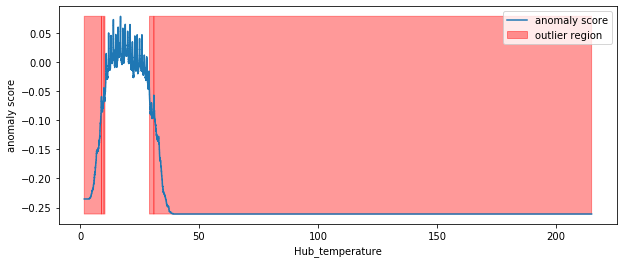

In [60]:
isolation_forest.fit(windfarm['Rt_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['Rt_avg'].dropna().min(), windfarm['Rt_avg'].dropna().max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Hub_temperature')
plt.show();

According to the above results and visualization, it seems that the Hub_temperature averages between 1* and 6* and greater than 38* C would be definitely considered as outliers.

In [61]:
# # Visually investigate some of these anomalies
# Using Mask for Hub_temperature > 38* C, show first 5
windfarm[(windfarm.Rt_avg > 38)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
71156,R80790,2016-08-26 16:40:00+00:00,2016-08-26,16:40:00,2016,8,0.11,-0.99,0.5,0.47,39.000000,39.0,39.060001,0.00,964.88000,957.65002,971.26001,2.210000,351.75000,49.380001,850.17999,229.33000,6.160000,-24.360001,54.889999,21.370001,5.000000,-8.14,26.680000,6.19,19.170000,0.57,57.529999,14.750000,1.00,-0.99,0.99,0.00,970.20001,962.87000,976.37000,2.21,40.480000,39.900002,41.099998,0.24,41.090000,40.700001,41.500000,0.12,55.779999,53.400002,58.349998,0.77,60.380001,60.099998,60.799999,0.14,57.820000,57.700001,58.299999,0.14,55.009998,54.750000,55.400002,0.10,55.880001,55.799999,56.099998,0.04,172.32001,172.32001,172.32001,0.0,35.000000,34.799999,35.000000,0.02,3.59,2.71,5.23,0.48,3.58,0.00,5.66,0.66,3.59,1.50,5.39,0.54,187.70000,123.37000,248.35001,18.879999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.40,-48.950001,76.029999,18.879999,31.900000,31.750000,32.099998,0.09,49.980000,49.950001,50.009998,0.01,695.34003,694.06000,696.72998,0.48,9.229999,9.15,9.35,0.04,38.380001,38.200001,38.400002,0.05,60.549999,-241.310000,539.44000,210.33000,NaN,NaN,NaN,NaN,187.70000,NaN,NaN,NaN,187.70000,NaN,NaN,NaN
82507,R80790,2016-08-27 11:50:00+00:00,2016-08-27,11:50:00,2016,8,-0.52,-0.99,0.5,0.51,38.430000,38.0,39.000000,0.42,968.59998,956.98999,1004.34000,9.080000,654.09998,-95.120003,1053.43010,256.07001,34.520000,-37.180000,78.699997,25.290001,22.900000,4.64,40.290001,6.63,46.990002,7.07,81.300003,15.510000,1.00,-1.00,0.91,0.02,973.79999,962.03003,1009.60000,9.11,46.830002,45.750000,47.900002,0.42,45.009998,44.500000,45.500000,0.18,62.799999,60.049999,65.500000,0.91,58.119999,57.799999,58.500000,0.18,57.770000,57.500000,58.049999,0.16,50.259998,49.799999,50.900002,0.19,55.349998,55.000000,55.700001,0.17,166.83000,166.83000,166.83000,0.0,36.720001,36.500000,37.000000,0.10,4.74,2.98,6.34,0.63,4.56,2.48,6.50,0.65,4.65,3.01,6.42,0.58,159.92999,136.60001,17.76000,105.110000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.90,-30.230000,-149.070010,105.110000,34.799999,34.500000,35.099998,0.15,49.990002,49.959999,50.009998,0.01,693.96002,692.50000,695.40997,0.57,9.270001,9.13,9.64,0.09,39.599998,39.500000,39.599998,0.01,337.109990,-368.010010,747.09003,245.39999,NaN,NaN,NaN,NaN,159.92999,NaN,NaN,NaN,159.92999,NaN,NaN,NaN
82510,R80790,2016-08-27 14:00:00+00:00,2016-08-27,14:00:00,2016,8,-0.86,-0.99,0.5,0.36,38.950001,38.0,39.000000,0.16,1031.93990,956.51001,1117.51000,45.849998,1028.99000,205.500000,1356.64000,258.76999,80.529999,-8.960000,126.900000,30.980000,16.809999,0.70,23.120001,4.49,83.269997,1.79,128.250000,29.309999,0.99,-1.00,0.94,0.01,1037.23000,961.51001,1123.18990,46.00,42.230000,41.250000,43.099998,0.26,42.520000,42.099998,42.950001,0.13,57.029999,54.500000,60.150002,0.90,65.089996,64.699997,65.500000,0.20,64.089996,63.700001,64.699997,0.26,58.849998,58.400002,59.450001,0.17,59.709999,59.500000,60.000000,0.09,173.41000,173.41000,173.41000,0.0,36.150002,36.099998,36.299999,0.05

## Univariate Anomaly Detection on Apparent_power 

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


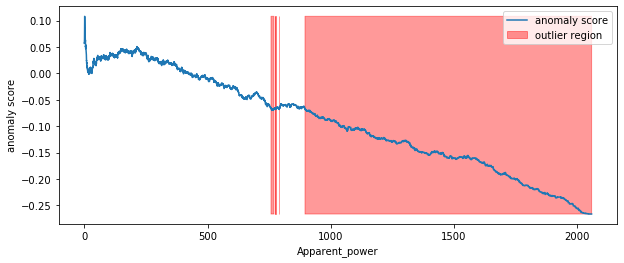

In [84]:
isolation_forest.fit(wf_R80721['S_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(wf_R80721['S_avg'].dropna().min(), wf_R80721['S_avg'].dropna().max(), len(wf_R80721)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Apparent_power')
plt.show();

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


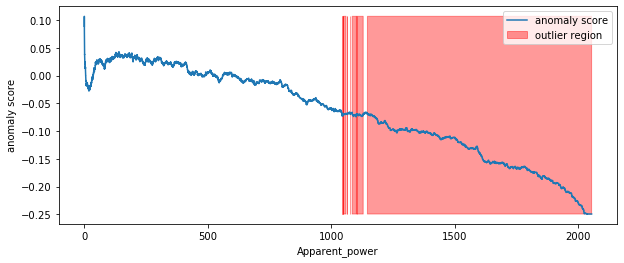

In [85]:
isolation_forest.fit(wf_R80711['S_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(wf_R80711['S_avg'].dropna().min(), wf_R80711['S_avg'].dropna().max(), len(wf_R80711)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Apparent_power')
plt.show();

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


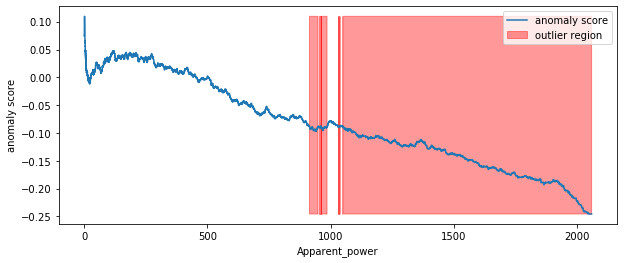

In [86]:
isolation_forest.fit(wf_R80736['S_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(wf_R80736['S_avg'].dropna().min(), wf_R80736['S_avg'].dropna().max(), len(wf_R80736)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Apparent_power')
plt.show();

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


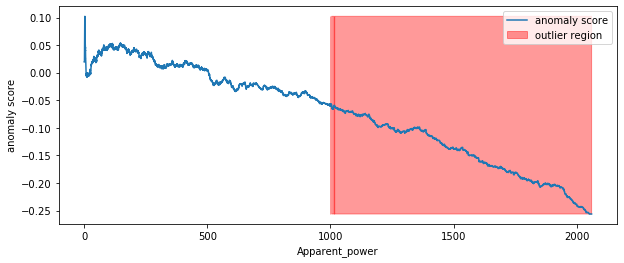

In [87]:
isolation_forest.fit(wf_R80790['S_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(wf_R80790['S_avg'].dropna().min(), wf_R80790['S_avg'].dropna().max(), len(wf_R80790)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Apparent_power')
plt.show();

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

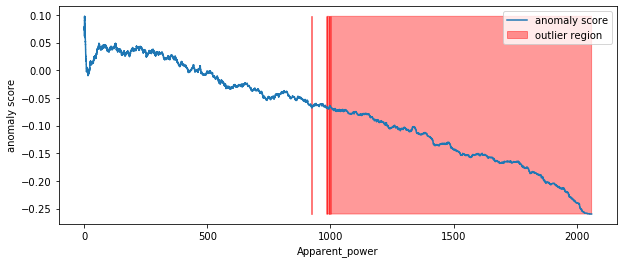

In [62]:
isolation_forest.fit(windfarm['S_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['S_avg'].dropna().min(), windfarm['S_avg'].dropna().max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Apparent_power')
plt.show();

According to the above results and visualization, it seems that the Apparent_power averages greater than 1125 would be definitely considered as outliers.

There seem to be some other outliers, but they do not appear to be as apparent.

In [63]:
# # Visually investigate some of these anomalies
# Using Mask for Apparent_power > 1125, show first 5
windfarm[(windfarm.S_avg > 1125)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
14028,R80736,2016-11-25 08:00:00+00:00,2016-11-25,08:00:00,2016,11,-0.74,-0.99,0.76,0.40,17.010000,17.0,17.940001,0.07,1735.0200,1372.5601,1839.3199,114.460000,6204.7900,2140.8799,10869.7000,2661.340100,1137.1500,279.92001,2043.6801,526.71002,81.379997,46.060001,121.18,15.65,1141.3400,288.20999,2045.2100,524.179990,0.99,1.0,0.96,0.01,1731.5100,1368.96,1835.7500,114.460000,37.590000,36.849998,38.000000,0.23,55.490002,54.700001,55.900002,0.24,66.660004,63.349998,68.300003,1.13,65.690002,63.200001,67.000000,1.15,71.410004,69.900002,72.000000,0.57,47.220001,42.799999,48.549999,1.72,55.160000,54.200001,55.650002,0.39,63.900002,63.900002,63.900002,0.0,14.270000,14.1,14.300000,0.04,9.46,4.86,14.650000,2.18,8.91,4.40,13.53,1.91,9.19,4.63,14.090000,2.02,57.950001,4.140000,94.860001,11.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.02,-59.770000,30.959999,11.80,8.41,8.40,8.5,0.02,49.990002,49.970001,50.020000,0.01,713.34003,709.88000,716.00000,1.70,16.520000,13.05,17.530001,1.10,27.00,27.000000,27.000000,0.00,6140.4800,1945.01,10799.40,2670.7300,NaN,NaN,NaN,NaN,57.950001,NaN,NaN,NaN,57.950001,NaN,NaN,NaN
14049,R80736,2016-11-04 22:30:00+00:00,2016-11-04,22:30:00,2016,11,-0.97,-0.99,-0.49,0.09,16.709999,16.0,17.000000,0.38,1797.8199,1674.8300,1825.7600,22.440001,6161.6401,3140.5801,9453.8398,1233.540000,1155.1801,546.56000,1779.6801,236.48000,80.900002,55.549999,108.13,11.59,1158.2800,556.57001,1781.2800,235.460010,1.00,1.0,0.98,0.00,1794.6600,1671.49,1822.5800,22.459999,34.860001,33.900002,36.099998,0.55,31.680000,31.000000,32.099998,0.25,55.639999,53.900002,57.450001,0.81,72.010002,71.150002,73.150002,0.51,74.209999,73.599998,74.650002,0.26,55.049999,52.299999,58.799999,2.63,59.590000,58.900002,60.400002,0.34,206.590000,206.590000,206.590000,0.0,21.290001,18.1,22.500000,1.05,9.12,5.48,12.900000,1.36,8.74,5.93,11.75,1.11,8.93,5.91,12.320000,1.19,206.170000,178.410000,248.910000,10.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.47,-28.180000,42.320000,10.04,9.14,9.00,9.3,0.08,49.990002,49.970001,50.009998,0.01,707.00000,703.97998,709.29999,1.18,17.129999,15.95,17.410000,0.22,27.77,27.700001,27.799999,0.04,6138.6401,3116.97,9415.21,1230.1200,NaN,NaN,NaN,NaN,206.170000,NaN,NaN,NaN,206.170000,NaN,NaN,NaN
14062,R80736,2016-11-16 13:00:00+00:00,2016-11-16,13:00:00,2016,11,-0.96,-0.99,0.83,0.18,15.380000,15.0,16.000000,0.42,1802.3199,1760.3199,1834.8900,9.410000,6494.5601,3542.1001,10690.8000,1199.840000,1218.9000,649.75000,2005.3300,226.59000,79.589996,52.990002,111.34,14.14,1221.6400,653.97998,2007.6200,226.280000,1.00,1.0,0.99,0.00,1798.9800,1756.89,1831.5400,9.400000,38.250000,36.950001,39.450001,0.63,34.009998,33.799999,34.349998,0.12,60.040001,57.849998,61.599998,0.86,72.820000,71.699997,73.800003,0.55,74.519997,74.099998,75.000000,0.21,53.459999,52.750000,56.700001,0.61,59.360001,58.650002,60.099998,0.31,218.660000,218.660000,218.660000,0.0,25.330000,25.1,26.200001,0.24,9.10,5

## Univariate Anomaly Detection on Vane_position    

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

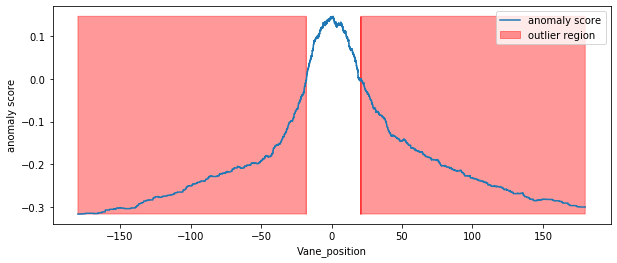

In [64]:
isolation_forest.fit(windfarm['Va_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['Va_avg'].dropna().min(), windfarm['Va_avg'].dropna().max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Vane_position')
plt.show();

According to the above results and visualization, it seems that the Vane_position averages less than -25 and greater than 25 would be definitely considered as outliers.

In [65]:
# # Visually investigate some of these anomalies
# Using Mask for Vane_position  > 25, show first 5
windfarm[(windfarm.Va_avg > 25)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
13878,R80736,2016-11-29 23:40:00+00:00,2016-11-29,23:40:00,2016,11,45.0,45.0,45.0,0.0,9.000000,9.0,9.94,0.05,94.430000,73.129997,107.930000,8.53,28.719999,28.450001,28.969999,0.08,-1.31,-1.78,-0.93,0.14,0.0,0.0,0.09,0.00,1.31,0.93,1.78,0.14,1.0,1.0,1.0,0.0,90.470001,68.980003,104.040000,8.520001,41.369999,41.200001,41.599998,0.12,35.139999,34.900002,35.500000,0.14,54.889999,54.599998,55.400002,0.21,46.560001,46.400002,46.599998,0.07,47.500000,47.299999,47.700001,0.14,47.549999,47.200001,47.900002,0.15,49.990002,49.799999,50.200001,0.10,81.459999,81.459999,81.459999,0.0,21.459999,21.200001,21.600000,0.06,0.34,0.0,1.96,0.68,2.32,1.73,2.76,0.22,1.33,0.86,2.36,0.39,125.340000,106.240000,141.37,5.32000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.910000,24.780001,59.910000,5.32000,0.070000,-0.1,0.2,0.11,49.980000,49.950001,50.009998,0.01,698.31000,697.03998,701.50000,0.87,0.86,0.66,0.99,0.08,20.320000,20.200001,20.400000,0.04,-139.710010,-187.47000,-85.459999,17.809999,NaN,NaN,NaN,NaN,125.340000,NaN,NaN,NaN,125.340000,NaN,NaN,NaN
13893,R80736,2016-11-30 09:20:00+00:00,2016-11-30,09:20:00,2016,11,45.0,45.0,45.0,0.0,11.000000,11.0,11.00,0.00,4.660000,4.630000,4.700000,0.01,28.219999,28.030001,28.420000,0.07,-0.47,-1.98,-0.06,0.48,0.0,0.0,0.13,0.01,0.47,0.06,1.98,0.48,1.0,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,31.680000,31.500000,31.799999,0.10,30.040001,29.799999,30.400000,0.15,53.020000,52.700001,53.299999,0.21,37.820000,37.400002,38.200001,0.18,40.759998,40.400002,41.099998,0.14,28.090000,26.000000,37.700001,2.44,44.020000,43.700001,44.599998,0.19,185.730000,185.730000,185.730000,0.0,14.150000,13.700000,14.600000,0.26,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,271.340000,234.429990,297.75,14.21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.610001,48.700001,112.020000,14.21000,4.210000,3.6,5.0,0.34,49.990002,49.950001,50.020000,0.02,700.40997,698.78998,702.40997,0.65,0.00,0.00,0.00,0.00,17.540001,17.299999,17.600000,0.05,0.000000,0.00000,0.000000,0.000000,NaN,NaN,NaN,NaN,271.340000,NaN,NaN,NaN,271.340000,NaN,NaN,NaN
13978,R80736,2016-11-14 16:10:00+00:00,2016-11-14,16:10:00,2016,11,45.0,45.0,45.0,0.0,11.000000,11.0,11.00,0.00,4.360000,4.290000,4.430000,0.03,25.719999,25.370001,26.160000,0.16,-0.17,-0.46,0.00,0.08,0.0,0.0,0.00,0.00,0.17,0.00,0.46,0.08,1.0,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,26.180000,26.000000,26.400000,0.08,28.799999,28.500000,29.000000,0.08,41.009998,40.799999,41.200001,0.12,33.500000,33.200001,33.700001,0.12,35.540001,35.299999,35.599998,0.05,32.180000,29.100000,33.700001,1.54,38.740002,38.599998,38.799999,0.08,2.440000,2.440000,2.440000,0.0,16.420000,16.000000,16.799999,0.24,0.00,0.0,0.00,0.00,0.93,0.00,2.23,0.96,0.47,0.00,1.11,0.48,107.440000,83.720001,119.16,5.80000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.000000,81.279999,116.720000,5.80000,1.570000,1.5,1.6,0.05,50.000000,49.980000,50.020000,0.01,699.59998,698.26001,70

## Univariate Anomaly Detection on Vane_position_1 

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

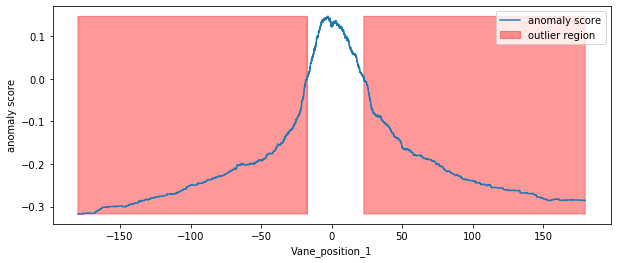

In [66]:
isolation_forest.fit(windfarm['Va1_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['Va1_avg'].dropna().min(), windfarm['Va1_avg'].dropna().max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Vane_position_1')
plt.show();

According to the above results and visualization, it seems that the Vane_position_1 averages less than -25 and greater than 25 would be definitely considered as outliers.

In [67]:
# # Visually investigate some of these anomalies
# Using Mask for Vane_position_1  > 25, show first 5
windfarm[(windfarm.Va1_avg > 25)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
243,R80711,2017-06-04 12:10:00+00:00,2017-06-04,12:10:00,2017,6,45.00,45.00,45.00,0.0,20.88,20.0,21.00,0.31,57.55,13.26,118.95,28.00,-9.62,-9.94,-9.21,0.12,0.0,-11.44,-0.20,2.87,-0.01,-2.56,0.06,0.11,4.06,0.20,11.71,2.87,1.0,-1.0,1.0,0.0,56.03,5.37,117.27,28.03,41.58,41.2,42.0,0.20,41.08,40.6,41.40,0.22,60.35,60.1,60.80,0.14,57.23,56.2,58.9,0.77,57.68,56.7,58.7,0.57,53.61,52.35,54.80,0.59,56.57,56.3,56.90,0.18,265.29,262.32,306.22,9.02,21.66,21.40,21.9,0.10,2.52,0.59,4.43,0.83,2.73,0.68,4.98,0.89,2.63,0.67,4.62,0.83,352.09,147.02,346.63,436.83,45.68,-115.30,84.31,440.31,45.68,-115.30,84.31,440.31,NaN,NaN,NaN,NaN,18.45,17.8,19.00,0.38,50.01,49.98,50.03,0.01,699.15,697.93,700.34,0.44,0.51,0.00,1.11,0.30,27.91,27.70,28.00,0.11,-336.46,-1828.95,0.0,471.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249,R80711,2017-06-04 15:10:00+00:00,2017-06-04,15:10:00,2017,6,45.00,45.00,45.00,0.0,21.00,21.0,21.00,0.00,48.81,13.41,92.07,23.67,-9.31,-9.79,-8.94,0.11,0.0,-3.73,-0.19,1.20,0.00,0.00,0.51,0.02,2.49,0.19,3.73,1.19,1.0,1.0,1.0,0.0,47.10,6.03,90.23,23.89,36.46,36.1,36.9,0.23,40.35,40.0,40.60,0.15,55.64,55.3,56.00,0.20,50.35,49.8,50.7,0.25,50.85,50.6,51.2,0.20,51.13,49.60,51.65,0.57,53.32,53.2,53.55,0.10,290.85,290.85,290.85,0.00,19.97,19.90,20.0,0.04,1.27,0.00,2.75,0.89,1.52,0.00,3.09,0.84,1.40,0.00,2.91,0.83,322.89,201.63,16.43,176.87,32.08,-89.23,85.58,176.87,32.08,-89.23,85.58,176.87,NaN,NaN,NaN,NaN,17.75,17.5,18.20,0.25,50.02,49.98,50.04,0.01,697.38,696.35,698.43,0.38,0.43,0.00,0.86,0.26,26.11,26.00,26.20,0.10,-146.10,-652.47,0.0,205.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
323,R80721,2017-05-15 00:10:00+00:00,2017-05-15,00:10:00,2017,5,44.99,44.99,44.99,0.0,23.01,23.0,23.88,0.06,28.23,22.63,35.28,3.47,2.74,2.45,3.03,0.10,0.0,-1.09,-0.53,0.09,0.00,0.00,0.19,0.01,0.80,0.53,1.09,0.09,1.0,1.0,1.0,0.0,28.66,22.84,35.95,3.50,38.52,38.5,38.7,0.05,37.10,37.1,37.20,0.01,52.38,52.2,52.60,0.12,54.01,53.5,54.5,0.28,54.26,54.1,54.5,0.12,51.07,47.50,53.50,2.04,55.91,55.7,56.10,0.11,298.36,298.36,298.36,0.00,28.19,27.95,28.5,0.14,1.35,0.00,2.70,1.03,0.93,0.00,2.48,0.99,1.14,0.00,2.59,0.95,357.61,335.29,18.08,4.79,59.26,36.94,79.72,4.79,59.26,36.94,79.72,4.79,NaN,NaN,NaN,NaN,14.46,14.4,14.50,0.05,49.99,49.97,50.01,0.01,705.13,704.09,706.66,0.40,0.27,0.22,0.35,0.03,29.71,29.55,29.85,0.10,0.00,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
327,R80721,2017-05-15 05:10:00+00:00,2017-05-15,05:10:00,2017,5,44.99,44.99,44.99,0.0,23.00,23.0,23.00,0.00,41.26,18.43,61.65,11.00,2.39,2.16,2.62,0.07,0.0,-1.73,-0.60,0.30,0.00,-0.53,0.13,0.02,1.04,0.60,1.73,0.30,1.0,1.0,1.0,0.0,41.45,18.34,61.85,11.01,34.47,34.4,34.6,0.09,32.22,32.2,32.30,0.03,40.31,40.1,40.45,0.10,44.88,44.6,45.0,0.11,45.75,45.6,45.9,0.08,46.24,44.40,47.30,0.98,48.31,47.9,48.70,0.19,28.36,28.36,28.36,0.00,26.60,26.50,26.7,0.02,1.15,0.00,2.66,0.95,0.83,0.00,2.27,0.83,0.99,0.00,2.42,0.86,68

## Univariate Anomaly Detection on Vane_position_2  

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

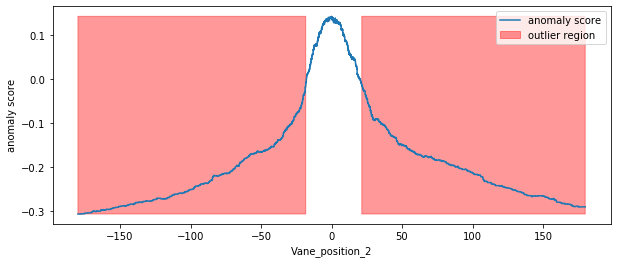

In [68]:
isolation_forest.fit(windfarm['Va2_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['Va2_avg'].dropna().min(), windfarm['Va2_avg'].dropna().max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Vane_position_2')
plt.show();

According to the above results and visualization, it seems that the Vane_position_2 averages less than -25 and greater than 25 would be definitely considered as outliers.

In [69]:
# # Visually investigate some of these anomalies
# Using Mask for Vane_position_2  > 25, show first 5
windfarm[(windfarm.Va2_avg > 25)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
243,R80711,2017-06-04 12:10:00+00:00,2017-06-04,12:10:00,2017,6,45.00,45.00,45.00,0.0,20.88,20.0,21.00,0.31,57.55,13.26,118.95,28.00,-9.62,-9.94,-9.21,0.12,0.0,-11.44,-0.20,2.87,-0.01,-2.56,0.06,0.11,4.06,0.20,11.71,2.87,1.0,-1.0,1.0,0.0,56.03,5.37,117.27,28.03,41.58,41.2,42.0,0.20,41.08,40.6,41.40,0.22,60.35,60.1,60.80,0.14,57.23,56.2,58.9,0.77,57.68,56.7,58.7,0.57,53.61,52.35,54.80,0.59,56.57,56.3,56.90,0.18,265.29,262.32,306.22,9.02,21.66,21.40,21.9,0.10,2.52,0.59,4.43,0.83,2.73,0.68,4.98,0.89,2.63,0.67,4.62,0.83,352.09,147.02,346.63,436.83,45.68,-115.30,84.31,440.31,45.68,-115.30,84.31,440.31,NaN,NaN,NaN,NaN,18.45,17.8,19.00,0.38,50.01,49.98,50.03,0.01,699.15,697.93,700.34,0.44,0.51,0.00,1.11,0.30,27.91,27.70,28.00,0.11,-336.46,-1828.95,0.0,471.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249,R80711,2017-06-04 15:10:00+00:00,2017-06-04,15:10:00,2017,6,45.00,45.00,45.00,0.0,21.00,21.0,21.00,0.00,48.81,13.41,92.07,23.67,-9.31,-9.79,-8.94,0.11,0.0,-3.73,-0.19,1.20,0.00,0.00,0.51,0.02,2.49,0.19,3.73,1.19,1.0,1.0,1.0,0.0,47.10,6.03,90.23,23.89,36.46,36.1,36.9,0.23,40.35,40.0,40.60,0.15,55.64,55.3,56.00,0.20,50.35,49.8,50.7,0.25,50.85,50.6,51.2,0.20,51.13,49.60,51.65,0.57,53.32,53.2,53.55,0.10,290.85,290.85,290.85,0.00,19.97,19.90,20.0,0.04,1.27,0.00,2.75,0.89,1.52,0.00,3.09,0.84,1.40,0.00,2.91,0.83,322.89,201.63,16.43,176.87,32.08,-89.23,85.58,176.87,32.08,-89.23,85.58,176.87,NaN,NaN,NaN,NaN,17.75,17.5,18.20,0.25,50.02,49.98,50.04,0.01,697.38,696.35,698.43,0.38,0.43,0.00,0.86,0.26,26.11,26.00,26.20,0.10,-146.10,-652.47,0.0,205.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
323,R80721,2017-05-15 00:10:00+00:00,2017-05-15,00:10:00,2017,5,44.99,44.99,44.99,0.0,23.01,23.0,23.88,0.06,28.23,22.63,35.28,3.47,2.74,2.45,3.03,0.10,0.0,-1.09,-0.53,0.09,0.00,0.00,0.19,0.01,0.80,0.53,1.09,0.09,1.0,1.0,1.0,0.0,28.66,22.84,35.95,3.50,38.52,38.5,38.7,0.05,37.10,37.1,37.20,0.01,52.38,52.2,52.60,0.12,54.01,53.5,54.5,0.28,54.26,54.1,54.5,0.12,51.07,47.50,53.50,2.04,55.91,55.7,56.10,0.11,298.36,298.36,298.36,0.00,28.19,27.95,28.5,0.14,1.35,0.00,2.70,1.03,0.93,0.00,2.48,0.99,1.14,0.00,2.59,0.95,357.61,335.29,18.08,4.79,59.26,36.94,79.72,4.79,59.26,36.94,79.72,4.79,NaN,NaN,NaN,NaN,14.46,14.4,14.50,0.05,49.99,49.97,50.01,0.01,705.13,704.09,706.66,0.40,0.27,0.22,0.35,0.03,29.71,29.55,29.85,0.10,0.00,0.00,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
327,R80721,2017-05-15 05:10:00+00:00,2017-05-15,05:10:00,2017,5,44.99,44.99,44.99,0.0,23.00,23.0,23.00,0.00,41.26,18.43,61.65,11.00,2.39,2.16,2.62,0.07,0.0,-1.73,-0.60,0.30,0.00,-0.53,0.13,0.02,1.04,0.60,1.73,0.30,1.0,1.0,1.0,0.0,41.45,18.34,61.85,11.01,34.47,34.4,34.6,0.09,32.22,32.2,32.30,0.03,40.31,40.1,40.45,0.10,44.88,44.6,45.0,0.11,45.75,45.6,45.9,0.08,46.24,44.40,47.30,0.98,48.31,47.9,48.70,0.19,28.36,28.36,28.36,0.00,26.60,26.50,26.7,0.02,1.15,0.00,2.66,0.95,0.83,0.00,2.27,0.83,0.99,0.00,2.42,0.86,68

## Univariate Anomaly Detection on Absolute_wind_direction (in degrees)

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

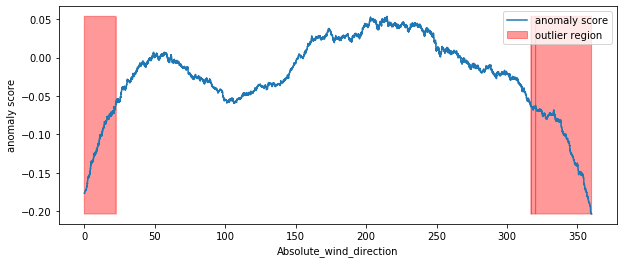

In [70]:
isolation_forest.fit(windfarm['Wa_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['Wa_avg'].dropna().min(), windfarm['Wa_avg'].dropna().max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Absolute_wind_direction')
plt.show();

According to the above results and visualization, it seems that the Absolute_wind_direction averages less than 25 and greater than 325 would be definitely considered as outliers.

There is also another small section of outliers, but their position does not appear to be as apparent.

In [71]:
# # Visually investigate some of these anomalies
# Using Mask for Absolute_wind_direction  > 325, show first 5
windfarm[(windfarm.Wa_avg > 325)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
13911,R80736,2016-11-14 12:50:00+00:00,2016-11-14,12:50:00,2016,11,45.00,45.00,45.00,0.00,11.000000,11.0,11.0,0.00,12.30,4.230000,43.549999,12.670000,25.400000,25.209999,25.590000,0.070000,-0.15,-0.410000,0.010000,0.07,0.00,0.000000,0.00,0.000000,0.15,0.00000,0.410000,0.07000,1.0,1.0,1.00,0.0,7.87000,-0.620000,40.240002,13.12000,32.799999,32.599998,33.000000,0.14,32.189999,32.099998,32.200001,0.02,48.459999,48.200001,48.700001,0.10,39.160000,38.799999,39.500000,0.17,41.369999,41.099998,41.500000,0.14,36.110001,32.400002,39.599998,2.46,44.090000,43.099998,44.500000,0.35,2.44000,2.44000,2.44000,0.0,19.629999,19.5,19.700001,0.09,0.000000,0.00,0.00,0.00,0.09,0.00,1.88,0.38,0.05,0.00,0.94,0.19,348.10999,276.28000,30.25000,14.690000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-14.330000,-86.160004,27.809999,14.690000,6.670000,5.2,7.700000,0.70,49.990002,49.959999,50.000000,0.01,700.87000,699.83002,701.84003,0.40,0.060000,0.00,0.38,0.13,17.620001,17.549999,17.799999,0.05,0.0000,0.0000,0.000000,0.000000,NaN,NaN,NaN,NaN,348.10999,NaN,NaN,NaN,348.10999,NaN,NaN,NaN
13959,R80736,2016-11-27 01:20:00+00:00,2016-11-27,01:20:00,2016,11,0.03,-0.49,0.50,0.14,16.230000,16.0,17.0,0.42,973.19,971.109990,975.409970,0.650000,398.519990,281.870000,568.400020,73.739998,12.13,0.910000,29.860001,7.09,3.63,0.000000,11.16,3.570000,13.09,1.38000,31.530001,7.71000,1.0,1.0,1.00,0.0,969.96997,968.030030,972.120000,0.62000,18.090000,17.600000,18.600000,0.21,20.120001,18.700001,21.299999,0.73,23.139999,21.100000,25.049999,0.97,41.840000,38.900002,44.299999,1.50,33.220001,32.150002,34.099998,0.46,28.510000,27.799999,29.200001,0.34,29.370001,28.900000,29.799999,0.20,356.95001,356.95001,356.95001,0.0,14.800000,14.6,15.100000,0.12,3.810000,3.18,4.46,0.26,3.60,3.05,4.28,0.24,3.70,3.14,4.28,0.23,338.57999,299.82999,23.42000,9.720000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-18.379999,-57.130001,26.469999,9.720000,8.210000,8.2,8.400000,0.04,50.000000,49.980000,50.020000,0.01,701.28003,699.97998,702.40997,0.57,9.229999,9.20,9.26,0.01,16.840000,16.600000,17.000000,0.12,119.4100,8.9300,293.959990,69.809998,NaN,NaN,NaN,NaN,338.57999,NaN,NaN,NaN,338.57999,NaN,NaN,NaN
14040,R80736,2016-07-30 23:50:00+00:00,2016-07-30,23:50:00,2016,7,26.85,0.50,45.00,21.66,27.740000,27.0,28.0,0.40,466.37,84.519997,973.500000,426.140010,61.919998,22.430000,179.259990,53.439999,-8.46,-26.059999,-3.050000,6.48,-0.18,-15.340000,2.54,1.410000,8.66,3.05000,33.270000,6.74000,1.0,1.0,1.00,0.0,463.31000,81.419998,970.349980,425.98999,41.240002,40.900002,42.250000,0.38,38.490002,38.099998,38.900002,0.17,60.020000,59.400002,61.750000,0.47,58.279999,56.599998,59.500000,0.97,57.610001,56.799999,58.299999,0.42,53.029999,51.200001,54.599998,1.35,55.869999,55.700001,56.000000,0.04,350.37000,350.37000,350.37000,0.0,23.760000,23.4,24.200001,0.23,2.440000,0.00,3.80,0.80,2.54,0.00,4.01,0.71,2.49,1.41,3.87,0.63,352.38000,276.88000,228.74001,26.459999,NaN,

## Univariate Anomaly Detection on Absolute_wind_direction_corrected 

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

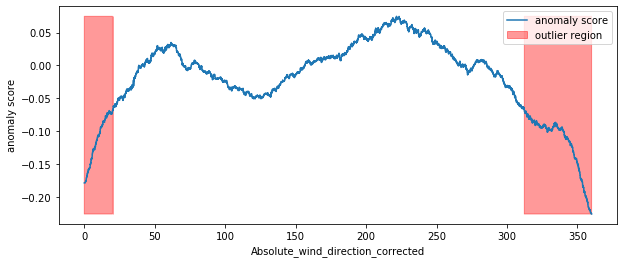

In [72]:
isolation_forest.fit(windfarm['Wa_c_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['Wa_c_avg'].dropna().min(), windfarm['Wa_c_avg'].dropna().max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Absolute_wind_direction_corrected')
plt.show();

According to the above results and visualization, it seems that the Absolute_wind_direction_corrected averages less than 25 and greater than 310 would be definitely considered as outliers.

There is also another small section of outliers, between ~ 120 and 140, but their position does not appear to be as apparent.

In [73]:
# # Visually investigate some of these anomalies
# Using Mask for Absolute_wind_direction_corrected  > 310, show first 5
windfarm[(windfarm.Wa_c_avg > 310)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
13908,R80736,2016-08-05 20:50:00+00:00,2016-08-05,20:50:00,2016,8,-0.99,-0.99,-0.99,0.00,24.010000,24.0,24.629999,0.05,1191.02000,1005.63000,1344.310100,112.46,1576.58000,1004.970000,2090.11010,337.510010,171.530000,76.330002,264.859990,61.400002,18.950001,11.72,21.900000,1.39,172.75,78.459999,265.429990,60.98,0.99,1.0,0.96,0.01,1187.78000,1002.46000,1341.040000,112.46,47.660000,46.750000,48.400002,0.34,42.000000,41.450001,42.549999,0.24,62.310001,60.849998,63.799999,0.51,66.849998,66.150002,67.300003,0.27,67.720001,66.400002,68.300003,0.60,58.180000,57.799999,58.500000,0.14,59.119999,58.799999,60.099998,0.10,309.76001,309.76001,309.76001,0.0,35.340000,35.099998,35.400002,0.08,5.19,3.87,6.89,0.67,5.15,3.78,6.88,0.60,5.17,3.82,6.74,0.61,312.37000,271.69000,34.060001,11.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.670000,-38.060001,84.300003,11.99,18.290001,18.200001,18.4,0.08,50.000000,49.970001,50.029999,0.01,697.33002,696.44000,698.98999,0.42,11.310000,9.53,12.80,1.08,32.799999,32.700001,32.849998,0.01,1343.79000,724.50000,1890.79000,373.640010,NaN,NaN,NaN,NaN,312.37000,NaN,NaN,NaN,312.37000,NaN,NaN,NaN
13911,R80736,2016-11-14 12:50:00+00:00,2016-11-14,12:50:00,2016,11,45.00,45.00,45.00,0.00,11.000000,11.0,11.000000,0.00,12.30000,4.23000,43.549999,12.67,25.40000,25.209999,25.59000,0.070000,-0.150000,-0.410000,0.010000,0.070000,0.000000,0.00,0.000000,0.00,0.15,0.000000,0.410000,0.07,1.00,1.0,1.00,0.00,7.87000,-0.62000,40.240002,13.12,32.799999,32.599998,33.000000,0.14,32.189999,32.099998,32.200001,0.02,48.459999,48.200001,48.700001,0.10,39.160000,38.799999,39.500000,0.17,41.369999,41.099998,41.500000,0.14,36.110001,32.400002,39.599998,2.46,44.090000,43.099998,44.500000,0.35,2.44000,2.44000,2.44000,0.0,19.629999,19.500000,19.700001,0.09,0.00,0.00,0.00,0.00,0.09,0.00,1.88,0.38,0.05,0.00,0.94,0.19,348.10999,276.28000,30.250000,14.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-14.330000,-86.160004,27.809999,14.69,6.670000,5.200000,7.7,0.70,49.990002,49.959999,50.000000,0.01,700.87000,699.83002,701.84003,0.40,0.060000,0.00,0.38,0.13,17.620001,17.549999,17.799999,0.05,0.00000,0.00000,0.00000,0.000000,NaN,NaN,NaN,NaN,348.10999,NaN,NaN,NaN,348.10999,NaN,NaN,NaN
13923,R80736,2016-08-06 01:00:00+00:00,2016-08-06,01:00:00,2016,8,-0.88,-0.99,0.00,0.24,24.209999,24.0,25.000000,0.38,974.64001,967.13000,992.390010,3.79,824.90997,558.219970,1044.61000,108.240000,53.700001,26.389999,77.610001,11.230000,17.700001,11.89,20.629999,1.41,56.66,31.139999,79.889999,10.83,0.99,1.0,0.93,0.03,971.25000,963.73999,988.950010,3.79,39.240002,38.200001,40.099998,0.46,37.279999,36.700001,37.900002,0.31,57.160000,55.450001,58.549999,0.55,62.250000,61.799999,62.599998,0.16,61.639999,61.299999,61.900002,0.18,56.799999,56.549999,57.099998,0.10,58.439999,58.250000,58.650002,0.06,309.76001,309.76001,309.76001,0.0,30.170000,29.600000,30.700001,0.30,4.03,2.96,5.42,0.39,4.06,3.08,5.73,0.43,4.05,3.22,5.57,0.39

## Univariate Anomaly Detection on Wind_speed   

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


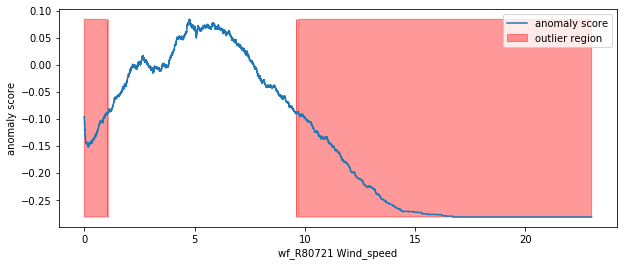

In [20]:
isolation_forest.fit(wf_R80721['Ws_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(wf_R80721['Ws_avg'].dropna().min(), wf_R80721['Ws_avg'].dropna().max(), len(wf_R80721)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('wf_R80721 Wind_speed')
plt.show();

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


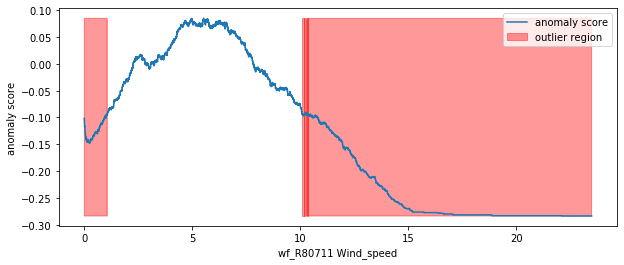

In [21]:
isolation_forest.fit(wf_R80711['Ws_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(wf_R80711['Ws_avg'].dropna().min(), wf_R80711['Ws_avg'].dropna().max(), len(wf_R80711)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('wf_R80711 Wind_speed')
plt.show();

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


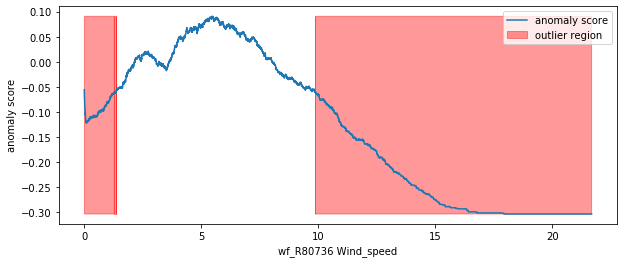

In [22]:
isolation_forest.fit(wf_R80736['Ws_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(wf_R80736['Ws_avg'].dropna().min(), wf_R80736['Ws_avg'].dropna().max(), len(wf_R80736)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('wf_R80736 Wind_speed')
plt.show();

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


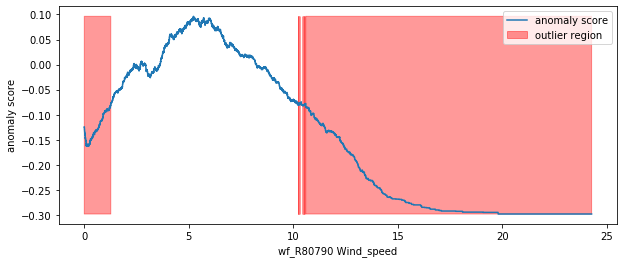

In [23]:
isolation_forest.fit(wf_R80790['Ws_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(wf_R80790['Ws_avg'].dropna().min(), wf_R80790['Ws_avg'].dropna().max(), len(wf_R80790)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('wf_R80790 Wind_speed')
plt.show();

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

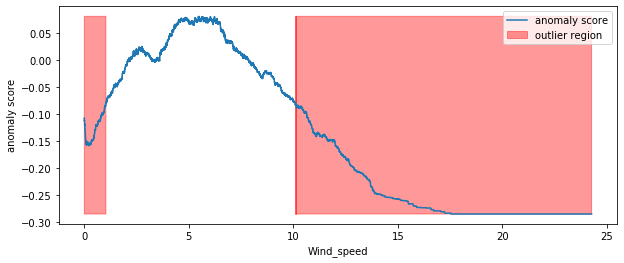

In [74]:
isolation_forest.fit(windfarm['Ws_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['Ws_avg'].dropna().min(), windfarm['Ws_avg'].dropna().max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Wind_speed')
plt.show();

According to the above results and visualization, it seems that the Wind_speed averages less than 1 and greater than 12 would be definitely considered as outliers.

There is also another small section of outliers, near 10, but its position does not appear to be as apparent.

In [75]:
# # Visually investigate some of these anomalies
# Using Mask for Wind_speed  > 12, show first 5
windfarm[(windfarm.Ws_avg > 12)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
14092,R80736,2016-11-25 03:50:00+00:00,2016-11-25,03:50:00,2016,11,9.54,1.71,15.47,3.04,17.00,17.0,17.0,0.00,1804.1400,1766.37,1878.9399,20.370001,10954.8,10744.3000,11006.3,23.280001,2050.0901,1974.2100,2136.4800,24.350000,181.84000,171.960010,188.48000,2.370000,2058.1399,1982.6801,2144.0801,24.209999,0.99,1.0,0.99,0.0,1800.6801,1762.78,1875.4301,20.360001,34.900002,34.599998,35.250000,0.10,35.689999,35.299999,36.049999,0.16,75.989998,74.699997,77.099998,0.41,69.919998,69.599998,70.250000,0.16,72.209999,72.099998,72.400002,0.03,47.869999,46.049999,50.349998,1.02,57.020000,56.650002,57.250000,0.10,55.119999,55.119999,55.119999,0.00,13.76,13.5,14.000000,0.09,15.25,9.450000,20.049999,2.02,14.14,9.13,18.910000,1.72,14.70,9.29,19.120001,1.84,51.169998,24.719999,81.400002,6.320000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.95,-30.400000,26.280001,6.320000,7.69,7.6,7.7,0.02,49.980000,49.959999,50.000000,0.01,711.69000,709.34003,714.00000,0.76,17.190001,16.830000,17.900000,0.20,27.180000,27.000000,27.200001,0.05,10871.9,10641.1000,10910.8,22.02000,NaN,NaN,NaN,NaN,51.169998,NaN,NaN,NaN,51.169998,NaN,NaN,NaN
14109,R80736,2016-11-28 10:10:00+00:00,2016-11-28,10:10:00,2016,11,4.92,-0.99,14.00,4.54,13.00,13.0,13.0,0.00,1803.3800,1764.38,1885.8600,18.459999,10297.8,5741.5601,11008.5,1173.330000,1927.4301,1067.4900,2145.8401,222.679990,168.74001,135.410000,187.45000,12.810000,1934.9399,1079.5500,2153.1699,221.850010,0.99,1.0,0.99,0.0,1800.0699,1761.03,1882.5000,18.459999,28.020000,27.600000,28.450001,0.19,26.590000,26.450001,26.750000,0.08,61.939999,60.400002,63.849998,0.85,67.540001,66.900002,68.099998,0.27,70.529999,70.300003,70.800003,0.11,42.599998,41.450001,44.049999,0.62,53.549999,53.250000,53.950001,0.14,50.560001,40.860001,50.730000,1.07,9.75,9.5,10.000000,0.12,13.91,8.770001,19.549999,2.33,13.08,7.59,18.040001,2.08,13.50,8.18,18.680000,2.19,33.240002,20.440001,72.260002,7.420000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.60,-30.290001,21.530001,7.490000,3.85,3.6,4.1,0.06,49.980000,49.959999,50.009998,0.01,712.67999,709.28003,715.70001,1.41,17.180000,16.799999,17.980000,0.18,25.200001,25.200001,25.250000,0.01,10222.4,5717.7500,10902.1,1157.66000,NaN,NaN,NaN,NaN,33.240002,NaN,NaN,NaN,33.240002,NaN,NaN,NaN
14155,R80736,2016-11-28 20:40:00+00:00,2016-11-28,20:40:00,2016,11,5.57,-0.99,13.22,3.75,12.90,12.0,13.0,0.26,1802.8199,1753.48,1884.2600,21.730000,10718.9,7771.0698,11002.6,597.580020,2005.0400,1443.4100,2144.6001,118.720000,176.56000,149.899990,188.85001,6.690000,2012.8400,1453.8700,2151.8701,118.180000,1.00,1.0,0.99,0.0,1799.7700,1750.36,1881.2400,21.730000,27.809999,27.549999,28.000000,0.08,25.389999,25.299999,25.600000,0.04,66.779999,66.050003,67.900002,0.31,67.790001,67.400002,68.150002,0.16,70.260002,70.000000,70.500000,0.07,41.110001,40.000000,42.000000,0.37,52.000000,51.700001,52.400002,0.13,47.439999,47.439999,47.439999,0.00,5.56,5.4,5.700000,0.09,12.79,8.01000

## Univariate Anomaly Detection on Wind_speed_1   

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


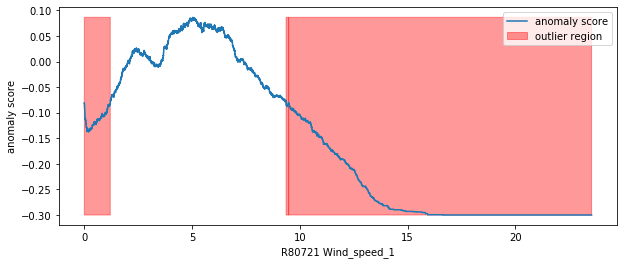

In [24]:
isolation_forest.fit(wf_R80721['Ws1_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(wf_R80721['Ws1_avg'].dropna().min(), wf_R80721['Ws1_avg'].dropna().max(), len(wf_R80721)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('R80721 Wind_speed_1')
plt.show();

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


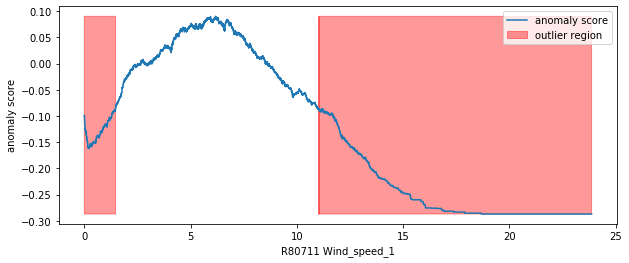

In [25]:
isolation_forest.fit(wf_R80711['Ws1_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(wf_R80711['Ws1_avg'].dropna().min(), wf_R80711['Ws1_avg'].dropna().max(), len(wf_R80711)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('R80711 Wind_speed_1')
plt.show();

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


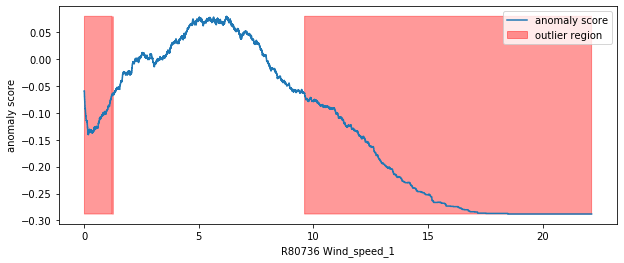

In [26]:
isolation_forest.fit(wf_R80736['Ws1_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(wf_R80736['Ws1_avg'].dropna().min(), wf_R80736['Ws1_avg'].dropna().max(), len(wf_R80736)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('R80736 Wind_speed_1')
plt.show();

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


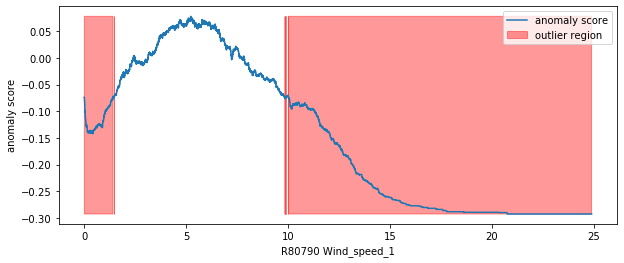

In [27]:
isolation_forest.fit(wf_R80790['Ws1_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(wf_R80790['Ws1_avg'].dropna().min(), wf_R80790['Ws1_avg'].dropna().max(), len(wf_R80790)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('R80790 Wind_speed_1')
plt.show();

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

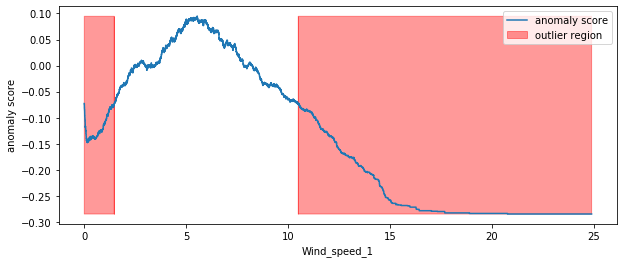

In [76]:
isolation_forest.fit(windfarm['Ws1_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['Ws1_avg'].dropna().min(), windfarm['Ws1_avg'].dropna().max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Wind_speed_1')
plt.show();

According to the above results and visualization, it seems that the Wind_speed_1 averages less than 1 and greater than 12 would be definitely considered as outliers.

In [77]:
# # Visually investigate some of these anomalies
# Using Mask for Wind_speed_1  > 12, show first 5
windfarm[(windfarm.Ws1_avg > 12)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
14092,R80736,2016-11-25 03:50:00+00:00,2016-11-25,03:50:00,2016,11,9.54,1.71,15.47,3.04,17.0,17.0,17.0,0.00,1804.1400,1766.3700,1878.9399,20.370001,10954.8,10744.3000,11006.3,23.280001,2050.0901,1974.21,2136.4800,24.35000,181.84000,171.96001,188.48000,2.370000,2058.1399,1982.6801,2144.0801,24.209999,0.99,1.0,0.99,0.0,1800.6801,1762.78,1875.4301,20.360001,34.900002,34.599998,35.250000,0.10,35.689999,35.299999,36.049999,0.16,75.989998,74.699997,77.099998,0.41,69.919998,69.599998,70.250000,0.16,72.209999,72.099998,72.400002,0.03,47.869999,46.049999,50.349998,1.02,57.020000,56.650002,57.250000,0.10,55.119999,55.119999,55.119999,0.00,13.76,13.5,14.0,0.09,15.25,9.450000,20.049999,2.02,14.14,9.13,18.910000,1.72,14.70,9.290000,19.120001,1.84,51.169998,24.719999,81.400002,6.320000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.95,-30.400000,26.280001,6.320000,7.69,7.6,7.7,0.02,49.980000,49.959999,50.000000,0.01,711.69000,709.34003,714.00000,0.76,17.190001,16.830000,17.900000,0.20,27.180000,27.000000,27.200001,0.05,10871.9,10641.1000,10910.8,22.02000,NaN,NaN,NaN,NaN,51.169998,NaN,NaN,NaN,51.169998,NaN,NaN,NaN
14109,R80736,2016-11-28 10:10:00+00:00,2016-11-28,10:10:00,2016,11,4.92,-0.99,14.00,4.54,13.0,13.0,13.0,0.00,1803.3800,1764.3800,1885.8600,18.459999,10297.8,5741.5601,11008.5,1173.330000,1927.4301,1067.49,2145.8401,222.67999,168.74001,135.41000,187.45000,12.810000,1934.9399,1079.5500,2153.1699,221.850010,0.99,1.0,0.99,0.0,1800.0699,1761.03,1882.5000,18.459999,28.020000,27.600000,28.450001,0.19,26.590000,26.450001,26.750000,0.08,61.939999,60.400002,63.849998,0.85,67.540001,66.900002,68.099998,0.27,70.529999,70.300003,70.800003,0.11,42.599998,41.450001,44.049999,0.62,53.549999,53.250000,53.950001,0.14,50.560001,40.860001,50.730000,1.07,9.75,9.5,10.0,0.12,13.91,8.770001,19.549999,2.33,13.08,7.59,18.040001,2.08,13.50,8.180000,18.680000,2.19,33.240002,20.440001,72.260002,7.420000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.60,-30.290001,21.530001,7.490000,3.85,3.6,4.1,0.06,49.980000,49.959999,50.009998,0.01,712.67999,709.28003,715.70001,1.41,17.180000,16.799999,17.980000,0.18,25.200001,25.200001,25.250000,0.01,10222.4,5717.7500,10902.1,1157.66000,NaN,NaN,NaN,NaN,33.240002,NaN,NaN,NaN,33.240002,NaN,NaN,NaN
14112,R80736,2016-11-28 19:10:00+00:00,2016-11-28,19:10:00,2016,11,3.35,-0.99,10.82,3.19,13.0,13.0,13.0,0.00,1801.3700,1768.9700,1866.2000,17.709999,10556.8,7941.2900,11003.6,719.960020,1973.3800,1479.71,2121.9299,139.75999,143.27000,107.89000,182.97000,16.549999,1978.6801,1487.4600,2126.3899,139.210010,1.00,1.0,0.99,0.0,1798.3300,1766.01,1863.1899,17.709999,29.879999,29.600000,30.200001,0.11,26.139999,25.900000,26.299999,0.06,66.040001,65.000000,67.099998,0.37,67.769997,67.349998,68.199997,0.20,70.730003,70.599998,71.000000,0.05,42.119999,41.450001,42.950001,0.29,53.680000,53.349998,54.099998,0.11,47.439999,47.439999,47.439999,0.00,6.32,6.2,6.5,0.06,12.03,7.820000,15.700000,1.2

## Univariate Anomaly Detection on Wind_speed_2   

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


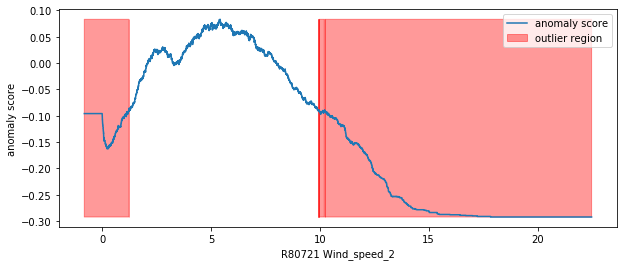

In [28]:
isolation_forest.fit(wf_R80721['Ws2_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(wf_R80721['Ws2_avg'].dropna().min(), wf_R80721['Ws2_avg'].dropna().max(), len(wf_R80721)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('R80721 Wind_speed_2')
plt.show();

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


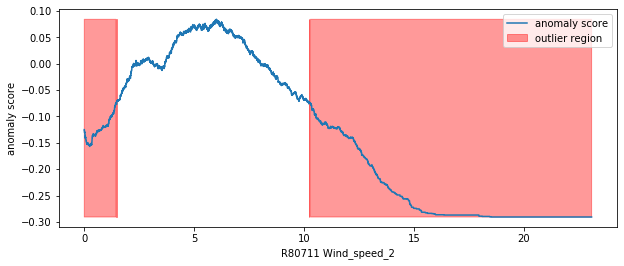

In [30]:
isolation_forest.fit(wf_R80711['Ws2_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(wf_R80711['Ws2_avg'].dropna().min(), wf_R80711['Ws2_avg'].dropna().max(), len(wf_R80711)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('R80711 Wind_speed_2')
plt.show();

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


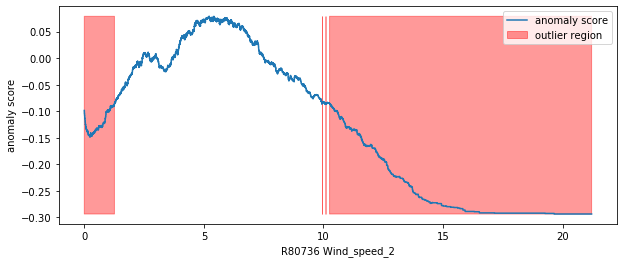

In [31]:
isolation_forest.fit(wf_R80736['Ws2_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(wf_R80736['Ws2_avg'].dropna().min(), wf_R80736['Ws2_avg'].dropna().max(), len(wf_R80736)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('R80736 Wind_speed_2')
plt.show();

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


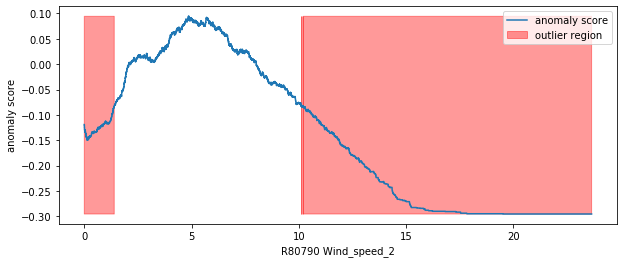

In [32]:
isolation_forest.fit(wf_R80790['Ws2_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(wf_R80790['Ws2_avg'].dropna().min(), wf_R80790['Ws2_avg'].dropna().max(), len(wf_R80790)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('R80790 Wind_speed_2')
plt.show();

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

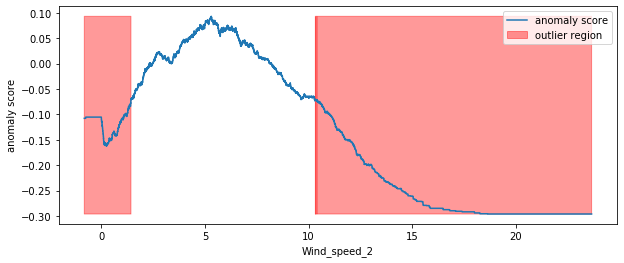

In [78]:
isolation_forest.fit(windfarm['Ws2_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['Ws2_avg'].dropna().min(), windfarm['Ws2_avg'].dropna().max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Wind_speed_2')
plt.show();

According to the above results and visualization, it seems that the Wind_speed_2 averages less than 1 and greater than 11 would be definitely considered as outliers.

In [79]:
# # Visually investigate some of these anomalies
# Using Mask for Wind_speed_2  > 11, show first 5
windfarm[(windfarm.Ws2_avg > 11)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
14092,R80736,2016-11-25 03:50:00+00:00,2016-11-25,03:50:00,2016,11,9.54,1.71,15.47,3.04,17.0,17.0,17.0,0.00,1804.1400,1766.3700,1878.9399,20.370001,10954.8,10744.3000,11006.3,23.280001,2050.0901,1974.21,2136.4800,24.35000,181.84000,171.96001,188.48000,2.370000,2058.1399,1982.6801,2144.0801,24.209999,0.99,1.0,0.99,0.0,1800.6801,1762.78,1875.4301,20.360001,34.900002,34.599998,35.250000,0.10,35.689999,35.299999,36.049999,0.16,75.989998,74.699997,77.099998,0.41,69.919998,69.599998,70.250000,0.16,72.209999,72.099998,72.400002,0.03,47.869999,46.049999,50.349998,1.02,57.020000,56.650002,57.250000,0.10,55.119999,55.119999,55.119999,0.00,13.76,13.5,14.0,0.09,15.25,9.450000,20.049999,2.02,14.14,9.13,18.910000,1.72,14.70,9.290000,19.120001,1.84,51.169998,24.719999,81.400002,6.320000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.95,-30.400000,26.280001,6.320000,7.69,7.6,7.7,0.02,49.980000,49.959999,50.000000,0.01,711.69000,709.34003,714.00000,0.76,17.190001,16.830000,17.900000,0.20,27.180000,27.000000,27.200001,0.05,10871.9,10641.1000,10910.8,22.02000,NaN,NaN,NaN,NaN,51.169998,NaN,NaN,NaN,51.169998,NaN,NaN,NaN
14109,R80736,2016-11-28 10:10:00+00:00,2016-11-28,10:10:00,2016,11,4.92,-0.99,14.00,4.54,13.0,13.0,13.0,0.00,1803.3800,1764.3800,1885.8600,18.459999,10297.8,5741.5601,11008.5,1173.330000,1927.4301,1067.49,2145.8401,222.67999,168.74001,135.41000,187.45000,12.810000,1934.9399,1079.5500,2153.1699,221.850010,0.99,1.0,0.99,0.0,1800.0699,1761.03,1882.5000,18.459999,28.020000,27.600000,28.450001,0.19,26.590000,26.450001,26.750000,0.08,61.939999,60.400002,63.849998,0.85,67.540001,66.900002,68.099998,0.27,70.529999,70.300003,70.800003,0.11,42.599998,41.450001,44.049999,0.62,53.549999,53.250000,53.950001,0.14,50.560001,40.860001,50.730000,1.07,9.75,9.5,10.0,0.12,13.91,8.770001,19.549999,2.33,13.08,7.59,18.040001,2.08,13.50,8.180000,18.680000,2.19,33.240002,20.440001,72.260002,7.420000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.60,-30.290001,21.530001,7.490000,3.85,3.6,4.1,0.06,49.980000,49.959999,50.009998,0.01,712.67999,709.28003,715.70001,1.41,17.180000,16.799999,17.980000,0.18,25.200001,25.200001,25.250000,0.01,10222.4,5717.7500,10902.1,1157.66000,NaN,NaN,NaN,NaN,33.240002,NaN,NaN,NaN,33.240002,NaN,NaN,NaN
14112,R80736,2016-11-28 19:10:00+00:00,2016-11-28,19:10:00,2016,11,3.35,-0.99,10.82,3.19,13.0,13.0,13.0,0.00,1801.3700,1768.9700,1866.2000,17.709999,10556.8,7941.2900,11003.6,719.960020,1973.3800,1479.71,2121.9299,139.75999,143.27000,107.89000,182.97000,16.549999,1978.6801,1487.4600,2126.3899,139.210010,1.00,1.0,0.99,0.0,1798.3300,1766.01,1863.1899,17.709999,29.879999,29.600000,30.200001,0.11,26.139999,25.900000,26.299999,0.06,66.040001,65.000000,67.099998,0.37,67.769997,67.349998,68.199997,0.20,70.730003,70.599998,71.000000,0.05,42.119999,41.450001,42.950001,0.29,53.680000,53.349998,54.099998,0.11,47.439999,47.439999,47.439999,0.00,6.32,6.2,6.5,0.06,12.03,7.820000,15.700000,1.2

## Univariate Anomaly Detection on Nacelle_angle   

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

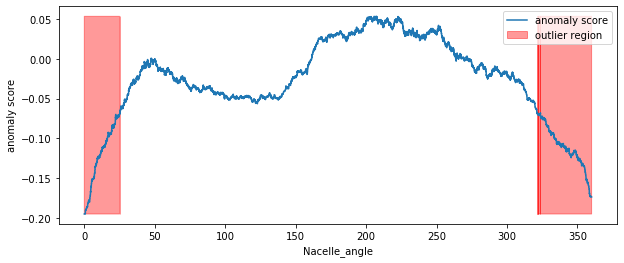

In [80]:
isolation_forest.fit(windfarm['Ya_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['Ya_avg'].dropna().min(), windfarm['Ya_avg'].dropna().max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Nacelle_angle')
plt.show();

According to the above results and visualization, it seems that the Nacelle_angle averages less than 20 and greater than 235 would be definitely considered as outliers.

In [81]:
# # Visually investigate some of these anomalies
# Using Mask for Nacelle_angle > 235, show first 5
windfarm[(windfarm.Ya_avg > 235)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
13887,R80736,2016-08-05 13:30:00+00:00,2016-08-05,13:30:00,2016,8,-0.75,-0.99,0.00,0.34,24.049999,24.0,25.000000,0.20,985.62,967.90002,1059.5300,21.750000,850.78003,501.45999,1247.6801,197.72000,55.34000,19.160000,102.51000,21.549999,13.930000,6.690000,19.549999,1.960000,57.470001,20.600000,103.13000,20.65000,0.99,1.0,0.95,0.02,981.95001,964.0000,1055.87,21.750000,39.139999,38.099998,40.099998,0.47,38.000000,37.299999,38.650002,0.31,57.509998,55.900002,59.400002,0.60,61.480000,60.900002,61.849998,0.24,61.540001,60.799999,61.900002,0.30,55.400002,55.099998,55.799999,0.11,57.180000,56.950001,57.349998,0.06,290.00000,290.00000,290.00000,0.0,23.889999,23.700001,24.000000,0.09,4.34,3.31,6.13,0.48,4.400000,3.39,6.51,0.48,4.37,3.35,6.32,0.45,293.41000,229.60001,355.049990,179.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.38,-60.400002,65.050003,179.95,19.969999,19.799999,20.1,0.09,49.990002,49.970001,50.020000,0.01,692.63000,691.08002,693.84003,0.53,9.340000,9.16,10.050000,0.21,31.850000,31.799999,32.000000,0.07,534.84003,189.23000,928.07001,197.69000,NaN,NaN,NaN,NaN,293.41000,NaN,NaN,NaN,293.41000,NaN,NaN,NaN
13896,R80736,2016-11-09 20:30:00+00:00,2016-11-09,20:30:00,2016,11,-0.98,-0.99,-0.38,0.05,14.000000,13.0,15.000000,0.22,1780.13,1641.17000,1827.0200,37.599998,4818.91990,3018.64990,8697.2100,1192.46000,895.33002,517.340030,1633.71000,233.910000,72.430000,41.740002,118.080000,15.990000,898.690000,520.000000,1636.36000,232.82001,1.00,1.0,0.98,0.00,1776.95000,1637.9700,1823.75,37.630001,34.840000,33.549999,36.099998,0.64,31.120001,30.900000,31.500000,0.14,58.689999,57.549999,59.750000,0.32,70.089996,69.000000,71.400002,0.76,73.260002,72.650002,73.800003,0.37,52.290001,51.650002,52.849998,0.25,58.279999,57.650002,59.000000,0.32,237.32001,237.32001,237.32001,0.0,21.900000,21.700001,22.000000,0.06,8.54,5.04,12.95,1.50,8.270001,5.40,12.61,1.28,8.40,5.48,12.78,1.37,232.48000,171.85001,276.769990,11.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.80,-65.470001,39.450001,11.13,6.100000,6.100000,6.2,0.01,50.000000,49.980000,50.020000,0.01,705.39001,703.23999,707.81000,0.97,16.959999,15.63,17.410000,0.36,26.480000,26.400000,26.600000,0.07,4795.29000,2971.33010,8647.62010,1192.28000,NaN,NaN,NaN,NaN,232.48000,NaN,NaN,NaN,232.48000,NaN,NaN,NaN
13899,R80736,2016-11-10 01:20:00+00:00,2016-11-10,01:20:00,2016,11,-0.99,-0.99,-0.99,0.00,13.000000,13.0,13.000000,0.00,1744.28,1584.14000,1825.2400,66.370003,4303.56010,2890.79000,8527.9297,1138.99000,783.12000,469.500000,1613.81010,233.730000,80.239998,41.810001,145.130000,19.030001,787.849980,480.120000,1615.81990,232.41000,0.99,1.0,0.97,0.01,1741.24000,1581.2000,1822.15,66.400002,35.650002,34.099998,37.299999,0.84,30.230000,29.500000,31.000000,0.40,57.189999,55.450001,59.349998,0.89,67.870003,65.900002,69.800003,1.08,71.769997,70.900002,72.750000,0.51,56.430000,55.299999,57.950001,0.70,57.380001,56.000000,58.349998,0.63,239.63000,235.12000,

##  Univariate Anomaly Detection on Nacelle_temperature (deg_C)  

/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/jcnachman/anaconda3/envs/metis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.prin

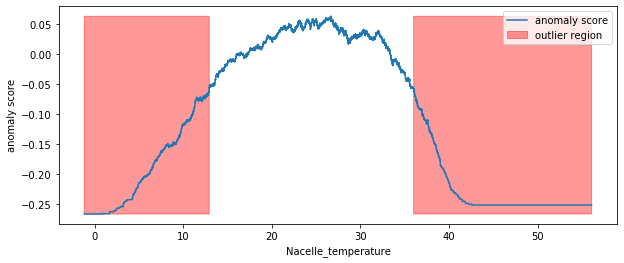

In [82]:
isolation_forest.fit(windfarm['Yt_avg'].dropna().values.reshape(-1, 1))

xx = np.linspace(windfarm['Yt_avg'].dropna().min(), windfarm['Yt_avg'].dropna().max(), len(windfarm)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Nacelle_temperature')
plt.show();

According to the above results and visualization, it seems that the Nacelle_temperature averages less than 11 and greater than 37 would be definitely considered as outliers.

There is also another small section of outliers, near 12 - 13, but its position does not appear to be as apparent.

In [83]:
# # Visually investigate some of these anomalies
# Using Mask for Nacelle_temperature > 37, show first 5
windfarm[(windfarm.Yt_avg > 37)].head()

,Wind_turbine_name,Date_time,Dates,Time,year,month,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,DCs_avg,DCs_min,DCs_max,DCs_std,Cm_avg,Cm_min,Cm_max,Cm_std,P_avg,P_min,P_max,P_std,Q_avg,Q_min,Q_max,Q_std,S_avg,S_min,S_max,S_std,Cosphi_avg,Cosphi_min,Cosphi_max,Cosphi_std,Ds_avg,Ds_min,Ds_max,Ds_std,Db1t_avg,Db1t_min,Db1t_max,Db1t_std,Db2t_avg,Db2t_min,Db2t_max,Db2t_std,Dst_avg,Dst_min,Dst_max,Dst_std,Gb1t_avg,Gb1t_min,Gb1t_max,Gb1t_std,Gb2t_avg,Gb2t_min,Gb2t_max,Gb2t_std,Git_avg,Git_min,Git_max,Git_std,Gost_avg,Gost_min,Gost_max,Gost_std,Ya_avg,Ya_min,Ya_max,Ya_std,Yt_avg,Yt_min,Yt_max,Yt_std,Ws1_avg,Ws1_min,Ws1_max,Ws1_std,Ws2_avg,Ws2_min,Ws2_max,Ws2_std,Ws_avg,Ws_min,Ws_max,Ws_std,Wa_avg,Wa_min,Wa_max,Wa_std,Va1_avg,Va1_min,Va1_max,Va1_std,Va2_avg,Va2_min,Va2_max,Va2_std,Va_avg,Va_min,Va_max,Va_std,Ot_avg,Ot_min,Ot_max,Ot_std,Nf_avg,Nf_min,Nf_max,Nf_std,Nu_avg,Nu_min,Nu_max,Nu_std,Rs_avg,Rs_min,Rs_max,Rs_std,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Pas_avg,Pas_min,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
14242,R80736,2016-08-03 21:20:00+00:00,2016-08-03,21:20:00,2016,8,-0.99,-0.99,-0.99,0.0,28.000000,28.0,28.0,0.00,1132.64,972.400020,1265.020000,101.320000,1396.800000,787.429990,1801.120000,294.73999,137.19,50.07,209.77,50.330002,22.24,7.28,29.129999,3.28,139.21001,54.310001,211.13,49.91,0.98,1.0,0.92,0.02,1128.8199,968.770020,1261.140000,101.310000,48.490002,47.799999,49.349998,0.31,44.439999,44.000000,44.900002,0.17,63.580002,62.049999,65.500000,0.56,63.599998,63.049999,64.599998,0.38,62.590000,61.849998,64.199997,0.75,55.639999,55.250000,56.650002,0.15,56.430000,56.049999,57.349998,0.16,199.620000,178.050000,206.590000,11.820000,37.549999,37.099998,38.099998,0.28,5.26,3.60,7.04,0.66,5.19,3.69,7.21,0.57,5.22,3.72,6.75,0.60,207.770000,155.490010,268.649990,10.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.190000,-38.799999,62.060001,16.24,23.590000,23.400000,23.799999,0.04,49.970001,49.939999,50.020000,0.02,701.35999,699.79999,702.53998,0.66,10.75,9.21,12.01,0.97,33.720001,33.599998,33.799999,0.04,1131.180100,493.23001,1588.360000,330.67999,NaN,NaN,NaN,NaN,207.770000,NaN,NaN,NaN,207.770000,NaN,NaN,NaN
14400,R80736,2016-07-19 15:30:00+00:00,2016-07-19,15:30:00,2016,7,45.00,45.00,45.00,0.0,33.220001,33.0,34.0,0.34,121.63,94.820000,141.289990,10.630000,23.879999,23.440001,24.299999,0.13000,-1.03,-1.39,-0.70,0.100000,0.00,-0.38,0.150000,0.02,1.03000,0.700000,1.39,0.11,1.00,1.0,1.00,0.00,118.3800,91.309998,137.950000,10.620000,41.560001,41.500000,41.700001,0.07,41.700001,41.599998,41.700001,0.02,43.139999,43.099998,43.299999,0.04,49.570000,49.400002,49.700001,0.08,48.369999,48.200001,48.400002,0.05,47.900002,47.799999,48.099998,0.03,48.400002,48.299999,48.500000,0.02,74.879997,74.879997,74.879997,0.000000,40.049999,39.900002,40.150002,0.08,2.99,1.71,3.86,0.43,2.79,1.63,3.61,0.39,2.89,1.73,3.73,0.40,65.269997,28.850000,106.470000,10.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.630000,-46.029999,31.590000,10.22,32.709999,32.500000,33.000000,0.12,49.970001,49.939999,50.009998,0.01,698.22998,696.46997,699.78003,0.52,1.12,0.87,1.31,0.10,34.189999,34.099998,34.200001,0.02,-83.949997,-138.25000,-49.119999,12.01000,NaN,NaN,NaN,NaN,65.269997,NaN,NaN,NaN,65.269997,NaN,NaN,NaN
14403,R80736,2016-07-19 15:40:00+00:00,2016-07-19,15:40:00,2016,7,45.00,45.00,45.00,0.0,33.349998,33.0,34.0,0.40,125.14,93.599998,174.759990,26.440001,23.920000,23.450001,24.400000,0.15000,-1.02,-1.31,-0.70,0.110000,0.00,-0.32,0.060000,0.01,1.02000,0.700000,1.45,0.11,1.00,1.0,1.00,0.00,121.8400,90.080002,171.149990,26.370001,41.689999,41.500000,41.700001,0.04,41.660000,41.500000,41.700001,0.06,43.029999,42.900002,43.099998,0.09,49.529999,49.400002,49.700001,0.06,48.259998,48.200001,48.400002,0.07,47.900002,47.700001,48.099998,0.03,48.419998,48.299999,48.500000,0.05,74.879997,74.879997,74.879997,0.000000,40.110001,39.900002,40.200001,0.05,2.70,1.30,4.21,0.68,2.61,1.45,4.11,0.61,2.66,1.37,4.06,0.63,73.720001,2